# Portfolio Strategy - LogReg Model

We will implement three portfolio strategies:

1. Shotgun then Prune
2. Prune Losers; Reinvest in Winners
3. Prune Losers; Reinvest in Winners and Newbies

<u>Strategy One - Shotgun then Prune </u>

**First sampling period (3-1-2009 to 12-31-2010)**

Divide cash (e.g. $10 million) evenly into N_1 (e.g. 100) tickers. Tickers are selected though random selection from an unranked prospect list from the Logistic Regression Algorithm. 

The prospect list is generated by sorting the tickers based on probability score and returning a fixed number of tickers (N_cutoff). N_cutoff is a hyperparameter.

**Subsequent sampling period (e.g. 3-1-2009 to 12-31-2011)**

Check tickers in the portfolio against the new prospect list. A ticker that is still on the list is considered a "winner". Tickers not on the list are "Losers" and are liquidated to raise cash. 

We repeat this process until the last sampling period (3-1-2009 to 12-31-2018).

**Final Tally** 

Tally up the investment gain by calculating the value of the portfolio (cash + stocks) on 3-31-2019.


<u>Strategy Two - Prune Losers; Reinvest in Winners</u>

**First sampling period (3-1-2009 to 12-31-2010)**

Same as Strategy One.

**Subsequent sampling period (e.g. 3-1-2009 to 12-31-2011)**

Cash raised by selling the Losers is reinvested evenly into the Winners.


<u>Strategy Three - Prune Losers; Reinvest in Winners and Newbies</u>

**First sampling period (3-1-2009 to 12-31-2010)**

Same as Strategy One.

**Subsequent sampling period (e.g. 3-1-2009 to 12-31-2011)**

Cash raised by selling the Losers is invested in new tickers selected from the new prospect list. Investment per ticker is the lesser of Available_Cash/N_new or 1e7/N_2, where N_new is the number of new tickers and N_2 is the number of tickers in the 2nd sampling period (e.g. 90).

If there is still cash left over after investing in these new tickers, it is reinvested evenly into the Winners.

<u>Benchmark against S&P (Jan 2011 - Mar 2019)</u>

The cumulative returns of these strategies are compared against the following S&P 500 returns over the period of Jan 2011 - Mar 2019:

* Total S&P 500 Return -	118.613%
* Annualized S&P 500 Return - 10.051%
* Total S&P 500 Return (Dividends Reinvested)	- 157.353%
* Annualized S&P 500 Return (Dividends Reinvested) - 12.271%


In [1]:
import quandl  # Access to Sharadar Core US Equities Bundle
api_key = '7B87ndLPJbCDzpNHosH3'

import math
import platform

from pylab import rcParams
import numpy as np
from sklearn import linear_model  # package for logistic regression (not using GPU)
import torch
import pandas as pd
from IPython.display import display
import time
import pickle
import random

from utils import *

from datetime import date, datetime, time, timedelta

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())
print("Pytorch version: {}".format(torch.__version__))

Python version:  3.6.6
Pytorch version: 1.1.0


## Import Stock Price History

In [2]:
stockprices = pd.read_csv("stock_price_history.cvs")
prices = stockprices.set_index('date')

In [3]:
# Files containing active tickers in the sampling periods
predict_filenames = ['predicts_lin_int_12-31-2010.csv',
              'predicts_lin_int_12-31-2011.csv',
              'predicts_lin_int_12-31-2012.csv',
              'predicts_lin_int_12-31-2013.csv',
              'predicts_lin_int_12-31-2014.csv',
              'predicts_lin_int_12-31-2015.csv',
              'predicts_lin_int_12-31-2016.csv',
              'predicts_lin_int_12-31-2017.csv',
              'predicts_lin_int_12-31-2018.csv'
             ]


# First January following end of sampling period when portfolio is rebalanced (bought and sold)
rebalance_periods = [
    ('2011-01-03','2011-01-31'),
    ('2012-01-03','2012-01-31'),
    ('2013-01-02','2013-01-31'),
    ('2014-01-02','2014-01-31'),
    ('2015-01-02','2015-01-31'),
    ('2016-01-04','2016-01-31'),
    ('2017-01-03','2017-01-31'),
    ('2018-01-02','2018-01-31'),
    ('2019-01-02','2019-01-31')
]

# End of sampling periods
end_dates = [
    '2010-12-31',
    '2011-12-30',
    '2012-12-31',
    '2013-12-31',
    '2014-12-31',
    '2015-12-31',
    '2016-12-30',
    '2017-12-29',    
    '2018-12-31'
]

# For Strategy One, only the first item is used
portfolio_sizes = [
    100,
    90,
    80,
    70,
    60,
    50,
    40,
    30,
    20
]

START = 1e7 # Start the portfolio with $10M

# the date where the final value of the portfolio is tallied
target_date = '2019-03-29'  

## Import Prospect Lists (Logistic Regression - Unranked)

In [25]:
score_tickers = pickle.load(open("prospects.pkl", "rb" ))
prospects = {}

for date, rebalance_period in zip(end_dates, rebalance_periods):
    
    prospects[date] = []
    
    # construct prospect list by picking the top 300 tickers
    tickers = []
    for score, ticker in score_tickers[date][:200]:
        tickers.append(ticker)
    
    for ticker in tickers:
        # Determine if ticker has delisted during buy period (First Jan following end of sampling period)
        start, end = rebalance_period
        delist = prices[ticker].loc[start:end].isnull().values.any()
        
        if not delist:
            prospects[date].append(ticker)  # add to prospect list if not delisted
            
    print('Num of tickers in sampling period ending {}: {}'.format(date, len(prospects[date])))


Num of tickers in sampling period ending 2010-12-31: 186
Num of tickers in sampling period ending 2011-12-30: 178
Num of tickers in sampling period ending 2012-12-31: 175
Num of tickers in sampling period ending 2013-12-31: 175
Num of tickers in sampling period ending 2014-12-31: 168
Num of tickers in sampling period ending 2015-12-31: 152
Num of tickers in sampling period ending 2016-12-30: 145
Num of tickers in sampling period ending 2017-12-29: 141
Num of tickers in sampling period ending 2018-12-31: 138


## Useful Functions

In [5]:
def random_select(prospects, num_tickers, invalids=[]):
    # Randomly pick a number of valid tickers from prospect_list
   
    if (len(prospects)-len(invalids)) < num_tickers:
        print('Not enough tickers in prospect list!')
        selections = None
    else:
        selections = []
        num = 0
        while num < num_tickers:
            ticker = random.sample(prospects, 1)  # pick a ticker
            if not (ticker[0] in invalids+selections):
                # print(ticker[0])
                # print(invalids+selections)
                selections.append(ticker[0])  # add to select if ticker is valid and has not been picked already
                num += 1
    return selections

def average_price(ticker, start, end):
    # Calculate average price of a ticker in period between start and end
    # The function assumes there is a global dataset "prices"
    
    # get the ticker's prices in the period (drop the NaNs)
    prices_history = list(prices[ticker].loc[start:end].dropna())   
    
    return sum(prices_history)/len(prices_history)

def liquidate(tickers, holdings, start, end, debug=False):
    # Liquidate holding in period between start and end
    # The function assumes there is a global dataset "prices"

    total = 0
    price_list = []
    
    for ticker in tickers:
        if math.isnan(prices[ticker].loc[start]):
            # If stock has been delisted before rebalance period, get price at date of delist
            delist_price = prices[ticker].loc[prices[ticker].last_valid_index()] 
            price_list.append(delist_price)
        else:
            price_list.append(average_price(ticker, start, end)) 
   
    for ticker, num_shares, price in zip(tickers, holdings, price_list):
        if debug:
            print("{}: Liquidate {:.1f} sh at ${:.2f}".format(ticker, num_shares, price))
        total += num_shares * price
        
    return total

def invest_evenly(tickers, holdings, cash, start, end, debug=False):
    # Invest the cash evenly between the tickers over the rebalancing period (defined by start and end). 
    # Return updated holding as a list. 
    
    new_holdings = []
    
    for ticker, holding in zip(tickers, holdings):

        buy_price = average_price(ticker, start, end) # find average price during rebalance period
        shares_added = cash/buy_price   # calculate and save number of shares bought
        new_holdings.append(holding + shares_added)

        if debug:
            print("{}: Buy {:.1f} sh at ${:.2f}".format(ticker, shares_added, buy_price))
    
    return new_holdings
    

def portfolio_value(tickers, holdings, date, debug=False):
    # Value of portfolio on a specific date
    # The function assumes there is a global dataset "prices"
    
    # print('Calculate value of stock holdings on {}:'.format(date))

    total = 0
    price_list = []
    
    for ticker in tickers:
        if math.isnan(prices[ticker].loc[date]):
            # If stock has been delisted before rebalance period, get price at date of delist
            delist_price = prices[ticker].loc[prices[ticker].last_valid_index()] 
            price_list.append(delist_price)
        else:
            price_list.append(prices[ticker].loc[date]) 
   
    for ticker, num_shares, price in zip(tickers, holdings, price_list):
        if debug:
            print("{}: {:.1f} sh at ${:.2f}".format(ticker, num_shares, price))
        total += num_shares * price
        
    return total

def identify_winners(tickers, prospects):
    # If a ticker in the portfolio is in the prospect list, identify it as a winner.
    
    winners = []
    losers = []
    
    for ticker in tickers:
        if ticker in prospects:
            winners.append(ticker)
        else:
            losers.append(ticker)
    
    return winners, losers

def prune_losers(portfolio, tickers, debug=False):
    # Take the input portfolio and prune away the losers
    loser_tickers = []
    loser_holdings = []
    new_portfolio = {}
    new_portfolio['tickers']=[]
    new_portfolio['num_shares']=[]
    
    for ticker, num_shares in zip(portfolio['tickers'], portfolio['num_shares']):
        if ticker in tickers:
            if debug:
                print('Loser: {}sh of {}'.format(num_shares, ticker))
            # Sell the losers
            loser_tickers.append(ticker)
            loser_holdings.append(num_shares) 
        else:
            # keep the winners
            if debug:
                print('Winner: {}sh of {}'.format(num_shares, ticker))
            new_portfolio['tickers'].append(ticker)
            new_portfolio['num_shares'].append(num_shares) 
            
    return new_portfolio, loser_tickers, loser_holdings

# Implement Strategy One (Shotgun then Prune)

In [18]:
num_iterations = 2000
returns = []
debug = False

for i in range(num_iterations):
    
    # Execute Strategy One 

    portfolio = {}
    last = None   # to save the last portfolio
    start_cash = START  # Start with $10M

    for date, num_tickers, rebalance_period in zip(end_dates,portfolio_sizes, rebalance_periods):
        
        if debug:
            print('Portfolio: {}'.format(date))
        start, end = rebalance_period

        if last is None:  # Create the portfolio for the first time

            if debug:
                print("Shotgun!")

            portfolio[date] = {}
            # Randomly select a set number of tickers from the prospect list (SHOTGUN)
            portfolio[date]['tickers'] = random_select(prospects[date], num_tickers)  
            portfolio[date]['num_shares'] = [0 for x in portfolio[date]['tickers']]

            # Invest cash evenly between the tickers
            invest = start_cash/num_tickers  
            portfolio[date]['num_shares'] = invest_evenly(portfolio[date]['tickers'], \
                                                         portfolio[date]['num_shares'], \
                                                         invest, start, end, debug=debug)

            last = portfolio[date].copy()   # Save a copy of the portfolio for later iterations
            cash = 0  # No more cash left

        else:   # Prune portfolio - Keep only the Winners

            if debug:
                print("Prune!")

            portfolio[date] = {}
            loser_tickers = []
            loser_holdings = []

            # If a ticker in the portfolio is on the new prospect list, keep it as a Winner.
            # If a ticker is not on the new prospect list, sell its position for cash
            winners, losers = identify_winners(last['tickers'], prospects[date])
            portfolio[date],loser_tickers,loser_holdings = prune_losers(last, losers, debug=debug)  

            # Liquidate Losers for cash during rebalance period
            liquidation = liquidate(loser_tickers, loser_holdings, start, end, debug=debug)
            cash += liquidation

            if debug:
                print('Winners: {}'.format(winners))
                print('Losers: {}'.format(losers))
                print('Cash harvested from Losers: ${:.2f}'.format(liquidation))   
                print('\n')

            last = portfolio[date].copy()   # Save portfolio for later iterations

    # Calculate value of the stock holdings on target date
    equity = portfolio_value(last['tickers'], last['num_shares'], target_date)
    total = equity + cash
    
    # Calculate and save portfolio return
    portfolio_return = (total/start_cash-1)*100
    returns.append(portfolio_return)

    print('Equity is valued at: ${:.2f}'.format(equity))
    print('Cash Position: ${:.2f}'.format(cash))
    print('Portfolio Total: ${:.2f}'.format(total))
    print('Portfolio appreciates by {:.1f} %'.format(portfolio_return))
    print('\n')
    
        
    

Equity is valued at: $0.00
Cash Position: $10464181.78
Portfolio Total: $10464181.78
Portfolio appreciates by 4.6 %


Equity is valued at: $0.00
Cash Position: $10782527.28
Portfolio Total: $10782527.28
Portfolio appreciates by 7.8 %


Equity is valued at: $0.00
Cash Position: $9830723.23
Portfolio Total: $9830723.23
Portfolio appreciates by -1.7 %


Equity is valued at: $0.00
Cash Position: $9841224.95
Portfolio Total: $9841224.95
Portfolio appreciates by -1.6 %


Equity is valued at: $838143.57
Cash Position: $10794623.07
Portfolio Total: $11632766.63
Portfolio appreciates by 16.3 %


Equity is valued at: $0.00
Cash Position: $9805447.69
Portfolio Total: $9805447.69
Portfolio appreciates by -1.9 %


Equity is valued at: $0.00
Cash Position: $10284709.77
Portfolio Total: $10284709.77
Portfolio appreciates by 2.8 %


Equity is valued at: $838143.57
Cash Position: $10494077.76
Portfolio Total: $11332221.33
Portfolio appreciates by 13.3 %


Equity is valued at: $0.00
Cash Position: $1001

Equity is valued at: $0.00
Cash Position: $10430967.47
Portfolio Total: $10430967.47
Portfolio appreciates by 4.3 %


Equity is valued at: $0.00
Cash Position: $9753594.13
Portfolio Total: $9753594.13
Portfolio appreciates by -2.5 %


Equity is valued at: $0.00
Cash Position: $10338096.35
Portfolio Total: $10338096.35
Portfolio appreciates by 3.4 %


Equity is valued at: $0.00
Cash Position: $10835682.78
Portfolio Total: $10835682.78
Portfolio appreciates by 8.4 %


Equity is valued at: $838143.57
Cash Position: $8947115.79
Portfolio Total: $9785259.36
Portfolio appreciates by -2.1 %


Equity is valued at: $0.00
Cash Position: $10923571.42
Portfolio Total: $10923571.42
Portfolio appreciates by 9.2 %


Equity is valued at: $0.00
Cash Position: $11342230.44
Portfolio Total: $11342230.44
Portfolio appreciates by 13.4 %


Equity is valued at: $0.00
Cash Position: $11349738.68
Portfolio Total: $11349738.68
Portfolio appreciates by 13.5 %


Equity is valued at: $0.00
Cash Position: $10096688

Equity is valued at: $0.00
Cash Position: $10597918.17
Portfolio Total: $10597918.17
Portfolio appreciates by 6.0 %


Equity is valued at: $0.00
Cash Position: $10544045.70
Portfolio Total: $10544045.70
Portfolio appreciates by 5.4 %


Equity is valued at: $0.00
Cash Position: $10278357.67
Portfolio Total: $10278357.67
Portfolio appreciates by 2.8 %


Equity is valued at: $838143.57
Cash Position: $10414693.98
Portfolio Total: $11252837.55
Portfolio appreciates by 12.5 %


Equity is valued at: $0.00
Cash Position: $9291601.49
Portfolio Total: $9291601.49
Portfolio appreciates by -7.1 %


Equity is valued at: $0.00
Cash Position: $9841767.67
Portfolio Total: $9841767.67
Portfolio appreciates by -1.6 %


Equity is valued at: $0.00
Cash Position: $9261575.99
Portfolio Total: $9261575.99
Portfolio appreciates by -7.4 %


Equity is valued at: $0.00
Cash Position: $11705169.08
Portfolio Total: $11705169.08
Portfolio appreciates by 17.1 %


Equity is valued at: $0.00
Cash Position: $10499582.

Equity is valued at: $0.00
Cash Position: $9635072.52
Portfolio Total: $9635072.52
Portfolio appreciates by -3.6 %


Equity is valued at: $0.00
Cash Position: $10016592.88
Portfolio Total: $10016592.88
Portfolio appreciates by 0.2 %


Equity is valued at: $838143.57
Cash Position: $9157482.22
Portfolio Total: $9995625.79
Portfolio appreciates by -0.0 %


Equity is valued at: $0.00
Cash Position: $10445206.78
Portfolio Total: $10445206.78
Portfolio appreciates by 4.5 %


Equity is valued at: $0.00
Cash Position: $9741452.48
Portfolio Total: $9741452.48
Portfolio appreciates by -2.6 %


Equity is valued at: $0.00
Cash Position: $10795359.59
Portfolio Total: $10795359.59
Portfolio appreciates by 8.0 %


Equity is valued at: $0.00
Cash Position: $10297757.80
Portfolio Total: $10297757.80
Portfolio appreciates by 3.0 %


Equity is valued at: $0.00
Cash Position: $10305489.97
Portfolio Total: $10305489.97
Portfolio appreciates by 3.1 %


Equity is valued at: $0.00
Cash Position: $10621960.21

Equity is valued at: $0.00
Cash Position: $11895507.10
Portfolio Total: $11895507.10
Portfolio appreciates by 19.0 %


Equity is valued at: $0.00
Cash Position: $10555256.94
Portfolio Total: $10555256.94
Portfolio appreciates by 5.6 %


Equity is valued at: $0.00
Cash Position: $10658221.68
Portfolio Total: $10658221.68
Portfolio appreciates by 6.6 %


Equity is valued at: $0.00
Cash Position: $9770340.97
Portfolio Total: $9770340.97
Portfolio appreciates by -2.3 %


Equity is valued at: $0.00
Cash Position: $10392623.52
Portfolio Total: $10392623.52
Portfolio appreciates by 3.9 %


Equity is valued at: $0.00
Cash Position: $9801094.94
Portfolio Total: $9801094.94
Portfolio appreciates by -2.0 %


Equity is valued at: $0.00
Cash Position: $9356821.49
Portfolio Total: $9356821.49
Portfolio appreciates by -6.4 %


Equity is valued at: $0.00
Cash Position: $10637153.94
Portfolio Total: $10637153.94
Portfolio appreciates by 6.4 %


Equity is valued at: $838143.57
Cash Position: $10150499.4

Equity is valued at: $0.00
Cash Position: $10739390.49
Portfolio Total: $10739390.49
Portfolio appreciates by 7.4 %


Equity is valued at: $0.00
Cash Position: $10738606.44
Portfolio Total: $10738606.44
Portfolio appreciates by 7.4 %


Equity is valued at: $838143.57
Cash Position: $11212732.14
Portfolio Total: $12050875.70
Portfolio appreciates by 20.5 %


Equity is valued at: $0.00
Cash Position: $10096107.65
Portfolio Total: $10096107.65
Portfolio appreciates by 1.0 %


Equity is valued at: $0.00
Cash Position: $9974744.31
Portfolio Total: $9974744.31
Portfolio appreciates by -0.3 %


Equity is valued at: $0.00
Cash Position: $9839527.84
Portfolio Total: $9839527.84
Portfolio appreciates by -1.6 %


Equity is valued at: $0.00
Cash Position: $9247880.45
Portfolio Total: $9247880.45
Portfolio appreciates by -7.5 %


Equity is valued at: $0.00
Cash Position: $11204411.33
Portfolio Total: $11204411.33
Portfolio appreciates by 12.0 %


Equity is valued at: $0.00
Cash Position: $10467238.

Equity is valued at: $0.00
Cash Position: $9895292.88
Portfolio Total: $9895292.88
Portfolio appreciates by -1.0 %


Equity is valued at: $0.00
Cash Position: $10912754.84
Portfolio Total: $10912754.84
Portfolio appreciates by 9.1 %


Equity is valued at: $0.00
Cash Position: $10098971.50
Portfolio Total: $10098971.50
Portfolio appreciates by 1.0 %


Equity is valued at: $0.00
Cash Position: $10728007.21
Portfolio Total: $10728007.21
Portfolio appreciates by 7.3 %


Equity is valued at: $0.00
Cash Position: $10661844.00
Portfolio Total: $10661844.00
Portfolio appreciates by 6.6 %


Equity is valued at: $838143.57
Cash Position: $10380454.31
Portfolio Total: $11218597.88
Portfolio appreciates by 12.2 %


Equity is valued at: $0.00
Cash Position: $9851933.88
Portfolio Total: $9851933.88
Portfolio appreciates by -1.5 %


Equity is valued at: $0.00
Cash Position: $9307051.49
Portfolio Total: $9307051.49
Portfolio appreciates by -6.9 %


Equity is valued at: $0.00
Cash Position: $9806561.59

Equity is valued at: $0.00
Cash Position: $10799929.88
Portfolio Total: $10799929.88
Portfolio appreciates by 8.0 %


Equity is valued at: $0.00
Cash Position: $9813872.75
Portfolio Total: $9813872.75
Portfolio appreciates by -1.9 %


Equity is valued at: $0.00
Cash Position: $9483237.21
Portfolio Total: $9483237.21
Portfolio appreciates by -5.2 %


Equity is valued at: $0.00
Cash Position: $11734778.94
Portfolio Total: $11734778.94
Portfolio appreciates by 17.3 %


Equity is valued at: $0.00
Cash Position: $10244609.29
Portfolio Total: $10244609.29
Portfolio appreciates by 2.4 %


Equity is valued at: $0.00
Cash Position: $10561266.22
Portfolio Total: $10561266.22
Portfolio appreciates by 5.6 %


Equity is valued at: $0.00
Cash Position: $9321440.09
Portfolio Total: $9321440.09
Portfolio appreciates by -6.8 %


Equity is valued at: $0.00
Cash Position: $11415932.77
Portfolio Total: $11415932.77
Portfolio appreciates by 14.2 %


Equity is valued at: $0.00
Cash Position: $10308196.52
Po

Equity is valued at: $838143.57
Cash Position: $11286469.16
Portfolio Total: $12124612.73
Portfolio appreciates by 21.2 %


Equity is valued at: $838143.57
Cash Position: $11016008.72
Portfolio Total: $11854152.28
Portfolio appreciates by 18.5 %


Equity is valued at: $0.00
Cash Position: $11110009.19
Portfolio Total: $11110009.19
Portfolio appreciates by 11.1 %


Equity is valued at: $838143.57
Cash Position: $9333970.05
Portfolio Total: $10172113.62
Portfolio appreciates by 1.7 %


Equity is valued at: $0.00
Cash Position: $10078117.83
Portfolio Total: $10078117.83
Portfolio appreciates by 0.8 %


Equity is valued at: $0.00
Cash Position: $11118902.40
Portfolio Total: $11118902.40
Portfolio appreciates by 11.2 %


Equity is valued at: $0.00
Cash Position: $10905988.49
Portfolio Total: $10905988.49
Portfolio appreciates by 9.1 %


Equity is valued at: $0.00
Cash Position: $9974969.21
Portfolio Total: $9974969.21
Portfolio appreciates by -0.3 %


Equity is valued at: $838143.57
Cash Po

Equity is valued at: $0.00
Cash Position: $10438119.28
Portfolio Total: $10438119.28
Portfolio appreciates by 4.4 %


Equity is valued at: $0.00
Cash Position: $10472133.25
Portfolio Total: $10472133.25
Portfolio appreciates by 4.7 %


Equity is valued at: $0.00
Cash Position: $10470380.40
Portfolio Total: $10470380.40
Portfolio appreciates by 4.7 %


Equity is valued at: $0.00
Cash Position: $10048412.73
Portfolio Total: $10048412.73
Portfolio appreciates by 0.5 %


Equity is valued at: $0.00
Cash Position: $11059155.62
Portfolio Total: $11059155.62
Portfolio appreciates by 10.6 %


Equity is valued at: $0.00
Cash Position: $10336530.34
Portfolio Total: $10336530.34
Portfolio appreciates by 3.4 %


Equity is valued at: $0.00
Cash Position: $10746375.76
Portfolio Total: $10746375.76
Portfolio appreciates by 7.5 %


Equity is valued at: $0.00
Cash Position: $10528659.99
Portfolio Total: $10528659.99
Portfolio appreciates by 5.3 %


Equity is valued at: $0.00
Cash Position: $10875291.90


Equity is valued at: $838143.57
Cash Position: $10220066.52
Portfolio Total: $11058210.09
Portfolio appreciates by 10.6 %


Equity is valued at: $0.00
Cash Position: $10040636.59
Portfolio Total: $10040636.59
Portfolio appreciates by 0.4 %


Equity is valued at: $0.00
Cash Position: $9007333.80
Portfolio Total: $9007333.80
Portfolio appreciates by -9.9 %


Equity is valued at: $0.00
Cash Position: $9544580.01
Portfolio Total: $9544580.01
Portfolio appreciates by -4.6 %


Equity is valued at: $838143.57
Cash Position: $9896344.20
Portfolio Total: $10734487.76
Portfolio appreciates by 7.3 %


Equity is valued at: $0.00
Cash Position: $10021753.69
Portfolio Total: $10021753.69
Portfolio appreciates by 0.2 %


Equity is valued at: $0.00
Cash Position: $10134934.84
Portfolio Total: $10134934.84
Portfolio appreciates by 1.3 %


Equity is valued at: $0.00
Cash Position: $10207305.76
Portfolio Total: $10207305.76
Portfolio appreciates by 2.1 %


Equity is valued at: $0.00
Cash Position: $10901

Equity is valued at: $0.00
Cash Position: $10388287.49
Portfolio Total: $10388287.49
Portfolio appreciates by 3.9 %


Equity is valued at: $0.00
Cash Position: $11167207.94
Portfolio Total: $11167207.94
Portfolio appreciates by 11.7 %


Equity is valued at: $0.00
Cash Position: $10252233.22
Portfolio Total: $10252233.22
Portfolio appreciates by 2.5 %


Equity is valued at: $0.00
Cash Position: $10596384.43
Portfolio Total: $10596384.43
Portfolio appreciates by 6.0 %


Equity is valued at: $0.00
Cash Position: $9611355.42
Portfolio Total: $9611355.42
Portfolio appreciates by -3.9 %


Equity is valued at: $0.00
Cash Position: $9961992.65
Portfolio Total: $9961992.65
Portfolio appreciates by -0.4 %


Equity is valued at: $0.00
Cash Position: $10269022.61
Portfolio Total: $10269022.61
Portfolio appreciates by 2.7 %


Equity is valued at: $0.00
Cash Position: $10474261.19
Portfolio Total: $10474261.19
Portfolio appreciates by 4.7 %


Equity is valued at: $0.00
Cash Position: $10421655.55
Po

Equity is valued at: $0.00
Cash Position: $8912469.86
Portfolio Total: $8912469.86
Portfolio appreciates by -10.9 %


Equity is valued at: $0.00
Cash Position: $9562774.55
Portfolio Total: $9562774.55
Portfolio appreciates by -4.4 %


Equity is valued at: $0.00
Cash Position: $9897072.56
Portfolio Total: $9897072.56
Portfolio appreciates by -1.0 %


Equity is valued at: $0.00
Cash Position: $10030902.07
Portfolio Total: $10030902.07
Portfolio appreciates by 0.3 %


Equity is valued at: $0.00
Cash Position: $9643802.41
Portfolio Total: $9643802.41
Portfolio appreciates by -3.6 %


Equity is valued at: $838143.57
Cash Position: $9750287.92
Portfolio Total: $10588431.49
Portfolio appreciates by 5.9 %


Equity is valued at: $838143.57
Cash Position: $11021962.91
Portfolio Total: $11860106.48
Portfolio appreciates by 18.6 %


Equity is valued at: $0.00
Cash Position: $11750433.47
Portfolio Total: $11750433.47
Portfolio appreciates by 17.5 %


Equity is valued at: $0.00
Cash Position: $98148

Equity is valued at: $0.00
Cash Position: $10751216.01
Portfolio Total: $10751216.01
Portfolio appreciates by 7.5 %


Equity is valued at: $0.00
Cash Position: $9606460.78
Portfolio Total: $9606460.78
Portfolio appreciates by -3.9 %


Equity is valued at: $0.00
Cash Position: $9236053.22
Portfolio Total: $9236053.22
Portfolio appreciates by -7.6 %


Equity is valued at: $0.00
Cash Position: $10063082.12
Portfolio Total: $10063082.12
Portfolio appreciates by 0.6 %


Equity is valued at: $0.00
Cash Position: $11063367.21
Portfolio Total: $11063367.21
Portfolio appreciates by 10.6 %


Equity is valued at: $0.00
Cash Position: $11869035.06
Portfolio Total: $11869035.06
Portfolio appreciates by 18.7 %


Equity is valued at: $0.00
Cash Position: $9965893.83
Portfolio Total: $9965893.83
Portfolio appreciates by -0.3 %


Equity is valued at: $0.00
Cash Position: $10422490.43
Portfolio Total: $10422490.43
Portfolio appreciates by 4.2 %


Equity is valued at: $0.00
Cash Position: $10194690.60
Po

Equity is valued at: $0.00
Cash Position: $10890307.89
Portfolio Total: $10890307.89
Portfolio appreciates by 8.9 %


Equity is valued at: $0.00
Cash Position: $10211674.71
Portfolio Total: $10211674.71
Portfolio appreciates by 2.1 %


Equity is valued at: $838143.57
Cash Position: $10829337.95
Portfolio Total: $11667481.52
Portfolio appreciates by 16.7 %


Equity is valued at: $0.00
Cash Position: $9845536.90
Portfolio Total: $9845536.90
Portfolio appreciates by -1.5 %


Equity is valued at: $0.00
Cash Position: $11127264.65
Portfolio Total: $11127264.65
Portfolio appreciates by 11.3 %


Equity is valued at: $0.00
Cash Position: $10296623.99
Portfolio Total: $10296623.99
Portfolio appreciates by 3.0 %


Equity is valued at: $838143.57
Cash Position: $9853034.95
Portfolio Total: $10691178.51
Portfolio appreciates by 6.9 %


Equity is valued at: $0.00
Cash Position: $11010553.79
Portfolio Total: $11010553.79
Portfolio appreciates by 10.1 %


Equity is valued at: $0.00
Cash Position: $10

Equity is valued at: $0.00
Cash Position: $9960569.66
Portfolio Total: $9960569.66
Portfolio appreciates by -0.4 %


Equity is valued at: $838143.57
Cash Position: $10373098.48
Portfolio Total: $11211242.04
Portfolio appreciates by 12.1 %


Equity is valued at: $0.00
Cash Position: $10592904.57
Portfolio Total: $10592904.57
Portfolio appreciates by 5.9 %


Equity is valued at: $838143.57
Cash Position: $10294143.77
Portfolio Total: $11132287.34
Portfolio appreciates by 11.3 %


Equity is valued at: $0.00
Cash Position: $10229970.72
Portfolio Total: $10229970.72
Portfolio appreciates by 2.3 %


Equity is valued at: $0.00
Cash Position: $9013540.56
Portfolio Total: $9013540.56
Portfolio appreciates by -9.9 %


Equity is valued at: $0.00
Cash Position: $10821899.51
Portfolio Total: $10821899.51
Portfolio appreciates by 8.2 %


Equity is valued at: $838143.57
Cash Position: $9633510.25
Portfolio Total: $10471653.82
Portfolio appreciates by 4.7 %


Equity is valued at: $0.00
Cash Position: 



Equity is valued at: $0.00
Cash Position: $8885710.76
Portfolio Total: $8885710.76
Portfolio appreciates by -11.1 %


Equity is valued at: $0.00
Cash Position: $8749335.12
Portfolio Total: $8749335.12
Portfolio appreciates by -12.5 %


Equity is valued at: $0.00
Cash Position: $10626880.46
Portfolio Total: $10626880.46
Portfolio appreciates by 6.3 %


Equity is valued at: $0.00
Cash Position: $11090786.69
Portfolio Total: $11090786.69
Portfolio appreciates by 10.9 %


Equity is valued at: $0.00
Cash Position: $9862203.43
Portfolio Total: $9862203.43
Portfolio appreciates by -1.4 %


Equity is valued at: $838143.57
Cash Position: $9258202.32
Portfolio Total: $10096345.89
Portfolio appreciates by 1.0 %


Equity is valued at: $0.00
Cash Position: $9742526.15
Portfolio Total: $9742526.15
Portfolio appreciates by -2.6 %


Equity is valued at: $0.00
Cash Position: $10157082.06
Portfolio Total: $10157082.06
Portfolio appreciates by 1.6 %


Equity is valued at: $0.00
Cash Position: $10052867

Equity is valued at: $0.00
Cash Position: $10341754.28
Portfolio Total: $10341754.28
Portfolio appreciates by 3.4 %


Equity is valued at: $0.00
Cash Position: $10180745.55
Portfolio Total: $10180745.55
Portfolio appreciates by 1.8 %


Equity is valued at: $838143.57
Cash Position: $10122955.89
Portfolio Total: $10961099.46
Portfolio appreciates by 9.6 %


Equity is valued at: $0.00
Cash Position: $10164642.27
Portfolio Total: $10164642.27
Portfolio appreciates by 1.6 %


Equity is valued at: $0.00
Cash Position: $10995517.44
Portfolio Total: $10995517.44
Portfolio appreciates by 10.0 %


Equity is valued at: $0.00
Cash Position: $10840651.63
Portfolio Total: $10840651.63
Portfolio appreciates by 8.4 %


Equity is valued at: $0.00
Cash Position: $10865949.13
Portfolio Total: $10865949.13
Portfolio appreciates by 8.7 %


Equity is valued at: $0.00
Cash Position: $9516400.34
Portfolio Total: $9516400.34
Portfolio appreciates by -4.8 %


Equity is valued at: $838143.57
Cash Position: $980

Equity is valued at: $0.00
Cash Position: $10161624.98
Portfolio Total: $10161624.98
Portfolio appreciates by 1.6 %


Equity is valued at: $0.00
Cash Position: $9841341.23
Portfolio Total: $9841341.23
Portfolio appreciates by -1.6 %


Equity is valued at: $0.00
Cash Position: $10246447.90
Portfolio Total: $10246447.90
Portfolio appreciates by 2.5 %


Equity is valued at: $0.00
Cash Position: $11063361.14
Portfolio Total: $11063361.14
Portfolio appreciates by 10.6 %


Equity is valued at: $0.00
Cash Position: $10370500.10
Portfolio Total: $10370500.10
Portfolio appreciates by 3.7 %


Equity is valued at: $838143.57
Cash Position: $9262798.74
Portfolio Total: $10100942.31
Portfolio appreciates by 1.0 %


Equity is valued at: $0.00
Cash Position: $9712288.63
Portfolio Total: $9712288.63
Portfolio appreciates by -2.9 %


Equity is valued at: $0.00
Cash Position: $10208029.06
Portfolio Total: $10208029.06
Portfolio appreciates by 2.1 %


Equity is valued at: $0.00
Cash Position: $10267373.7

Equity is valued at: $0.00
Cash Position: $10070002.68
Portfolio Total: $10070002.68
Portfolio appreciates by 0.7 %


Equity is valued at: $0.00
Cash Position: $10983868.73
Portfolio Total: $10983868.73
Portfolio appreciates by 9.8 %


Equity is valued at: $0.00
Cash Position: $10355597.19
Portfolio Total: $10355597.19
Portfolio appreciates by 3.6 %


Equity is valued at: $0.00
Cash Position: $10746711.38
Portfolio Total: $10746711.38
Portfolio appreciates by 7.5 %


Equity is valued at: $0.00
Cash Position: $10912181.99
Portfolio Total: $10912181.99
Portfolio appreciates by 9.1 %


Equity is valued at: $0.00
Cash Position: $10117346.77
Portfolio Total: $10117346.77
Portfolio appreciates by 1.2 %


Equity is valued at: $0.00
Cash Position: $9743824.63
Portfolio Total: $9743824.63
Portfolio appreciates by -2.6 %


Equity is valued at: $0.00
Cash Position: $10001466.31
Portfolio Total: $10001466.31
Portfolio appreciates by 0.0 %


Equity is valued at: $0.00
Cash Position: $10927560.18
Po

Equity is valued at: $0.00
Cash Position: $10370165.94
Portfolio Total: $10370165.94
Portfolio appreciates by 3.7 %


Equity is valued at: $0.00
Cash Position: $11244146.17
Portfolio Total: $11244146.17
Portfolio appreciates by 12.4 %


Equity is valued at: $838143.57
Cash Position: $11084526.64
Portfolio Total: $11922670.21
Portfolio appreciates by 19.2 %


Equity is valued at: $0.00
Cash Position: $10142522.08
Portfolio Total: $10142522.08
Portfolio appreciates by 1.4 %


Equity is valued at: $0.00
Cash Position: $9937245.03
Portfolio Total: $9937245.03
Portfolio appreciates by -0.6 %


Equity is valued at: $0.00
Cash Position: $10070477.37
Portfolio Total: $10070477.37
Portfolio appreciates by 0.7 %


Equity is valued at: $0.00
Cash Position: $10569572.82
Portfolio Total: $10569572.82
Portfolio appreciates by 5.7 %


Equity is valued at: $838143.57
Cash Position: $10364554.96
Portfolio Total: $11202698.53
Portfolio appreciates by 12.0 %


Equity is valued at: $0.00
Cash Position: $9

Equity is valued at: $0.00
Cash Position: $9550745.14
Portfolio Total: $9550745.14
Portfolio appreciates by -4.5 %


Equity is valued at: $0.00
Cash Position: $9475689.29
Portfolio Total: $9475689.29
Portfolio appreciates by -5.2 %


Equity is valued at: $0.00
Cash Position: $10546170.09
Portfolio Total: $10546170.09
Portfolio appreciates by 5.5 %


Equity is valued at: $838143.57
Cash Position: $9176460.39
Portfolio Total: $10014603.96
Portfolio appreciates by 0.1 %


Equity is valued at: $0.00
Cash Position: $10907601.65
Portfolio Total: $10907601.65
Portfolio appreciates by 9.1 %


Equity is valued at: $0.00
Cash Position: $11665703.81
Portfolio Total: $11665703.81
Portfolio appreciates by 16.7 %


Equity is valued at: $0.00
Cash Position: $9995743.03
Portfolio Total: $9995743.03
Portfolio appreciates by -0.0 %


Equity is valued at: $0.00
Cash Position: $10957412.76
Portfolio Total: $10957412.76
Portfolio appreciates by 9.6 %


Equity is valued at: $838143.57
Cash Position: $938292

Equity is valued at: $0.00
Cash Position: $10312075.99
Portfolio Total: $10312075.99
Portfolio appreciates by 3.1 %


Equity is valued at: $0.00
Cash Position: $10468939.17
Portfolio Total: $10468939.17
Portfolio appreciates by 4.7 %


Equity is valued at: $0.00
Cash Position: $11349366.52
Portfolio Total: $11349366.52
Portfolio appreciates by 13.5 %


Equity is valued at: $0.00
Cash Position: $10129591.76
Portfolio Total: $10129591.76
Portfolio appreciates by 1.3 %


Equity is valued at: $0.00
Cash Position: $10548743.28
Portfolio Total: $10548743.28
Portfolio appreciates by 5.5 %


Equity is valued at: $0.00
Cash Position: $10144478.18
Portfolio Total: $10144478.18
Portfolio appreciates by 1.4 %


Equity is valued at: $0.00
Cash Position: $10703005.97
Portfolio Total: $10703005.97
Portfolio appreciates by 7.0 %


Equity is valued at: $0.00
Cash Position: $10529143.19
Portfolio Total: $10529143.19
Portfolio appreciates by 5.3 %


Equity is valued at: $0.00
Cash Position: $10870082.13


Equity is valued at: $0.00
Cash Position: $10180677.68
Portfolio Total: $10180677.68
Portfolio appreciates by 1.8 %


Equity is valued at: $0.00
Cash Position: $9709216.73
Portfolio Total: $9709216.73
Portfolio appreciates by -2.9 %


Equity is valued at: $0.00
Cash Position: $11152280.37
Portfolio Total: $11152280.37
Portfolio appreciates by 11.5 %


Equity is valued at: $0.00
Cash Position: $9709427.99
Portfolio Total: $9709427.99
Portfolio appreciates by -2.9 %


Equity is valued at: $0.00
Cash Position: $8979372.24
Portfolio Total: $8979372.24
Portfolio appreciates by -10.2 %


Equity is valued at: $0.00
Cash Position: $9899225.41
Portfolio Total: $9899225.41
Portfolio appreciates by -1.0 %


Equity is valued at: $0.00
Cash Position: $11250748.60
Portfolio Total: $11250748.60
Portfolio appreciates by 12.5 %


Equity is valued at: $0.00
Cash Position: $11118104.29
Portfolio Total: $11118104.29
Portfolio appreciates by 11.2 %


Equity is valued at: $0.00
Cash Position: $10195244.31
P

Equity is valued at: $0.00
Cash Position: $12519549.61
Portfolio Total: $12519549.61
Portfolio appreciates by 25.2 %


Equity is valued at: $0.00
Cash Position: $10647223.28
Portfolio Total: $10647223.28
Portfolio appreciates by 6.5 %


Equity is valued at: $0.00
Cash Position: $11068186.42
Portfolio Total: $11068186.42
Portfolio appreciates by 10.7 %


Equity is valued at: $0.00
Cash Position: $10613410.90
Portfolio Total: $10613410.90
Portfolio appreciates by 6.1 %


Equity is valued at: $0.00
Cash Position: $9768528.34
Portfolio Total: $9768528.34
Portfolio appreciates by -2.3 %


Equity is valued at: $838143.57
Cash Position: $11018695.11
Portfolio Total: $11856838.67
Portfolio appreciates by 18.6 %


Equity is valued at: $0.00
Cash Position: $10429246.60
Portfolio Total: $10429246.60
Portfolio appreciates by 4.3 %


Equity is valued at: $0.00
Cash Position: $10851920.80
Portfolio Total: $10851920.80
Portfolio appreciates by 8.5 %


Equity is valued at: $0.00
Cash Position: $967501

Equity is valued at: $0.00
Cash Position: $9800852.85
Portfolio Total: $9800852.85
Portfolio appreciates by -2.0 %


Equity is valued at: $0.00
Cash Position: $11141705.10
Portfolio Total: $11141705.10
Portfolio appreciates by 11.4 %


Equity is valued at: $0.00
Cash Position: $10273796.81
Portfolio Total: $10273796.81
Portfolio appreciates by 2.7 %


Equity is valued at: $0.00
Cash Position: $10769736.10
Portfolio Total: $10769736.10
Portfolio appreciates by 7.7 %


Equity is valued at: $0.00
Cash Position: $9933853.49
Portfolio Total: $9933853.49
Portfolio appreciates by -0.7 %


Equity is valued at: $0.00
Cash Position: $10240489.46
Portfolio Total: $10240489.46
Portfolio appreciates by 2.4 %


Equity is valued at: $0.00
Cash Position: $10460038.86
Portfolio Total: $10460038.86
Portfolio appreciates by 4.6 %


Equity is valued at: $0.00
Cash Position: $11398076.44
Portfolio Total: $11398076.44
Portfolio appreciates by 14.0 %


Equity is valued at: $0.00
Cash Position: $9577243.56
Po

Equity is valued at: $0.00
Cash Position: $9851873.89
Portfolio Total: $9851873.89
Portfolio appreciates by -1.5 %


Equity is valued at: $0.00
Cash Position: $10335394.07
Portfolio Total: $10335394.07
Portfolio appreciates by 3.4 %


Equity is valued at: $0.00
Cash Position: $11490223.11
Portfolio Total: $11490223.11
Portfolio appreciates by 14.9 %


Equity is valued at: $0.00
Cash Position: $10830073.86
Portfolio Total: $10830073.86
Portfolio appreciates by 8.3 %


Equity is valued at: $0.00
Cash Position: $10835069.56
Portfolio Total: $10835069.56
Portfolio appreciates by 8.4 %


Equity is valued at: $0.00
Cash Position: $9924211.58
Portfolio Total: $9924211.58
Portfolio appreciates by -0.8 %


Equity is valued at: $0.00
Cash Position: $10419955.01
Portfolio Total: $10419955.01
Portfolio appreciates by 4.2 %


Equity is valued at: $0.00
Cash Position: $9598149.59
Portfolio Total: $9598149.59
Portfolio appreciates by -4.0 %


Equity is valued at: $0.00
Cash Position: $10523440.68
Por

Equity is valued at: $0.00
Cash Position: $11033983.40
Portfolio Total: $11033983.40
Portfolio appreciates by 10.3 %


Equity is valued at: $0.00
Cash Position: $10301280.53
Portfolio Total: $10301280.53
Portfolio appreciates by 3.0 %


Equity is valued at: $838143.57
Cash Position: $10147262.91
Portfolio Total: $10985406.48
Portfolio appreciates by 9.9 %


Equity is valued at: $0.00
Cash Position: $9957512.65
Portfolio Total: $9957512.65
Portfolio appreciates by -0.4 %


Equity is valued at: $0.00
Cash Position: $10575985.56
Portfolio Total: $10575985.56
Portfolio appreciates by 5.8 %


Equity is valued at: $0.00
Cash Position: $10318666.08
Portfolio Total: $10318666.08
Portfolio appreciates by 3.2 %


Equity is valued at: $0.00
Cash Position: $10499827.13
Portfolio Total: $10499827.13
Portfolio appreciates by 5.0 %


Equity is valued at: $0.00
Cash Position: $9781618.87
Portfolio Total: $9781618.87
Portfolio appreciates by -2.2 %


Equity is valued at: $0.00
Cash Position: $10688496.

Strategy One Return - mean:4.1%, std:6.7%


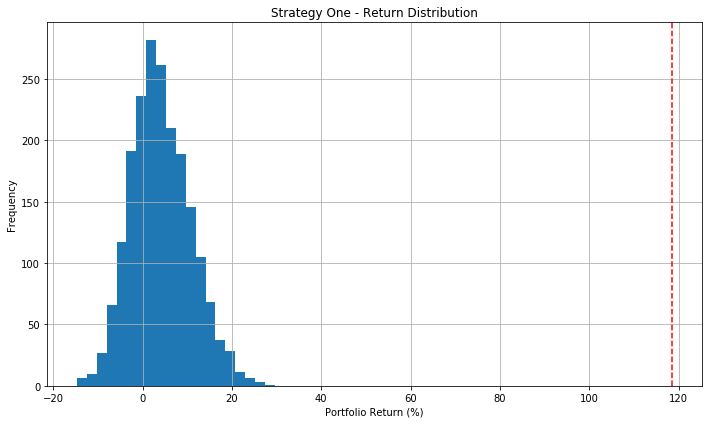

In [19]:
import statistics

print ("Strategy One Return - mean:{:.1f}%, std:{:.1f}%".format(statistics.mean(returns),statistics.stdev(returns)))
plt.figure(figsize=(10, 6))
num_bins = 20
plt.hist(returns,num_bins)
plt.xlabel('Portfolio Return (%)')
plt.ylabel("Frequency")
plt.title("Strategy One - Return Distribution")

plt.axvline(x=118.613, color="red", linestyle='--')
plt.grid(True)
plt.tight_layout()

plt.show()

# Implement Strategy Two - Prune Losers & Reinvest in Winners

In [20]:
num_iterations = 2000
returns = []
debug = False

for i in range(num_iterations):
    
    # Execute Strategy Two 

    portfolio = {}  # for storing portfolio info
    last = None   # to save a copy of the portfolio prior to rebalancing
    cash = START  # Start with $10M in cash

    for date, num_tickers, rebalance_period in zip(end_dates,portfolio_sizes, rebalance_periods):

        if debug:
            print('Portfolio: {}'.format(date))
        start, end = rebalance_period

        if last is None:  # Build the portfolio by investing starter cash evenly in a number of tickers

            if debug:
                print("Invest Evenly into {} tickers!".format(num_tickers))

            portfolio[date] = {}
            # Randomly select a set number of tickers from the prospect list (SHOTGUN)
            portfolio[date]['tickers'] = random_select(prospects[date], num_tickers)  
            portfolio[date]['num_shares'] = [0 for x in portfolio[date]['tickers']]

            # Invest cash evenly between the tickers
            invest = start_cash/num_tickers  
            portfolio[date]['num_shares'] = invest_evenly(portfolio[date]['tickers'], \
                                                         portfolio[date]['num_shares'], \
                                                         invest, start, end, debug=debug)

            last = portfolio[date]   # Save a copy of the portfolio for later iterations
            cash = 0  # No more cash left

        else:   # Rebalance portfolio - Let Winners run, Cut Losers Loose

            if debug:
                print("Let Winners run!")

            portfolio[date] = {}
            new_portfolio = {}
            loser_tickers = []
            loser_holdings = []

            # If a ticker in the portfolio is on the new prospect list, keep it as a Winner.
            # If a ticker is not on the new prospect list, sell its position for cash
            winners, losers = identify_winners(last['tickers'], prospects[date])
            
            if len(losers) is not 0:  # if there are losers
                
                # create new portfolio by pruning the losers
                new_portfolio, loser_tickers,loser_holdings = prune_losers(last, losers, debug=debug)  

                # Liquidate Losers for cash during rebalance period
                liquidation = liquidate(loser_tickers, loser_holdings, start, end, debug=debug)
                cash += liquidation
            else:
                new_portfolio = last  # no change to the portfolio
            
            if debug:
                print('Winners: {}'.format(winners))
                print('Losers: {}'.format(losers))
                print('Cash harvested from Losers: ${:.2f}'.format(liquidation))   

           
            if cash > 0 and len(new_portfolio['tickers']) > 0:
                # If there is cash left over and there are winners left, invest it evenly into the winners
                
                num_winners = len(new_portfolio['tickers'])
                if debug:
                    print("Invest ${:.2f} into {} Winners!".format(cash, num_winners))

                # Invest cash evenly between the tickers
                invest = cash/num_winners  
                new_portfolio['num_shares'] = invest_evenly(new_portfolio['tickers'], \
                                                             new_portfolio['num_shares'], \
                                                             invest, start, end, debug=debug)
                cash = 0  # No more cash left

            # Merge Newbies and Winners into final portfolio        
            # portfolio[date]['tickers'] = winner_tickers + newbie_tickers
            # portfolio[date]['num_shares'] = winner_holdings + newbie_holdings
            portfolio[date] = new_portfolio
            
            last = portfolio[date].copy()   # Save portfolio for later iterations

    # Calculate value of the stock holdings on target date
    equity = portfolio_value(last['tickers'], last['num_shares'], target_date)
    total = equity + cash
    
    # Calculate and save portfolio return
    portfolio_return = (total/start_cash-1)*100
    returns.append(portfolio_return)

    print('Equity is valued at: ${:.2f}'.format(equity))
    print('Cash Position: ${:.2f}'.format(cash))
    print('Portfolio Total: ${:.2f}'.format(total))
    print('Portfolio appreciates by {:.1f} %'.format(portfolio_return))
    print('\n')

Equity is valued at: $0.00
Cash Position: $16103493.14
Portfolio Total: $16103493.14
Portfolio appreciates by 61.0 %


Equity is valued at: $0.00
Cash Position: $25471970.08
Portfolio Total: $25471970.08
Portfolio appreciates by 154.7 %


Equity is valued at: $0.00
Cash Position: $16275536.35
Portfolio Total: $16275536.35
Portfolio appreciates by 62.8 %


Equity is valued at: $0.00
Cash Position: $38850409.18
Portfolio Total: $38850409.18
Portfolio appreciates by 288.5 %


Equity is valued at: $0.00
Cash Position: $5191113.73
Portfolio Total: $5191113.73
Portfolio appreciates by -48.1 %


Equity is valued at: $0.00
Cash Position: $30498457.83
Portfolio Total: $30498457.83
Portfolio appreciates by 205.0 %


Equity is valued at: $0.00
Cash Position: $12543573.77
Portfolio Total: $12543573.77
Portfolio appreciates by 25.4 %


Equity is valued at: $0.00
Cash Position: $10995860.57
Portfolio Total: $10995860.57
Portfolio appreciates by 10.0 %


Equity is valued at: $0.00
Cash Position: $277

Equity is valued at: $0.00
Cash Position: $12738505.30
Portfolio Total: $12738505.30
Portfolio appreciates by 27.4 %


Equity is valued at: $28133443.81
Cash Position: $0.00
Portfolio Total: $28133443.81
Portfolio appreciates by 181.3 %


Equity is valued at: $0.00
Cash Position: $15969345.63
Portfolio Total: $15969345.63
Portfolio appreciates by 59.7 %


Equity is valued at: $0.00
Cash Position: $11342079.75
Portfolio Total: $11342079.75
Portfolio appreciates by 13.4 %


Equity is valued at: $39681513.16
Cash Position: $0.00
Portfolio Total: $39681513.16
Portfolio appreciates by 296.8 %


Equity is valued at: $0.00
Cash Position: $12163499.38
Portfolio Total: $12163499.38
Portfolio appreciates by 21.6 %


Equity is valued at: $0.00
Cash Position: $18019866.37
Portfolio Total: $18019866.37
Portfolio appreciates by 80.2 %


Equity is valued at: $0.00
Cash Position: $20034722.17
Portfolio Total: $20034722.17
Portfolio appreciates by 100.3 %


Equity is valued at: $0.00
Cash Position: $28

Equity is valued at: $23817441.55
Cash Position: $0.00
Portfolio Total: $23817441.55
Portfolio appreciates by 138.2 %


Equity is valued at: $0.00
Cash Position: $23725305.44
Portfolio Total: $23725305.44
Portfolio appreciates by 137.3 %


Equity is valued at: $0.00
Cash Position: $46409952.38
Portfolio Total: $46409952.38
Portfolio appreciates by 364.1 %


Equity is valued at: $0.00
Cash Position: $16115669.11
Portfolio Total: $16115669.11
Portfolio appreciates by 61.2 %


Equity is valued at: $34926192.01
Cash Position: $0.00
Portfolio Total: $34926192.01
Portfolio appreciates by 249.3 %


Equity is valued at: $18732704.03
Cash Position: $0.00
Portfolio Total: $18732704.03
Portfolio appreciates by 87.3 %


Equity is valued at: $0.00
Cash Position: $24420292.47
Portfolio Total: $24420292.47
Portfolio appreciates by 144.2 %


Equity is valued at: $0.00
Cash Position: $38065135.10
Portfolio Total: $38065135.10
Portfolio appreciates by 280.7 %


Equity is valued at: $0.00
Cash Position: 

Equity is valued at: $0.00
Cash Position: $13066539.93
Portfolio Total: $13066539.93
Portfolio appreciates by 30.7 %


Equity is valued at: $0.00
Cash Position: $25146807.40
Portfolio Total: $25146807.40
Portfolio appreciates by 151.5 %


Equity is valued at: $0.00
Cash Position: $16137516.72
Portfolio Total: $16137516.72
Portfolio appreciates by 61.4 %


Equity is valued at: $0.00
Cash Position: $4496703.31
Portfolio Total: $4496703.31
Portfolio appreciates by -55.0 %


Equity is valued at: $0.00
Cash Position: $23642383.97
Portfolio Total: $23642383.97
Portfolio appreciates by 136.4 %


Equity is valued at: $0.00
Cash Position: $23616653.76
Portfolio Total: $23616653.76
Portfolio appreciates by 136.2 %


Equity is valued at: $0.00
Cash Position: $19354241.15
Portfolio Total: $19354241.15
Portfolio appreciates by 93.5 %


Equity is valued at: $0.00
Cash Position: $35600224.82
Portfolio Total: $35600224.82
Portfolio appreciates by 256.0 %


Equity is valued at: $0.00
Cash Position: $44

Equity is valued at: $0.00
Cash Position: $14487631.70
Portfolio Total: $14487631.70
Portfolio appreciates by 44.9 %


Equity is valued at: $0.00
Cash Position: $16272320.47
Portfolio Total: $16272320.47
Portfolio appreciates by 62.7 %


Equity is valued at: $21959109.09
Cash Position: $0.00
Portfolio Total: $21959109.09
Portfolio appreciates by 119.6 %


Equity is valued at: $0.00
Cash Position: $29422107.06
Portfolio Total: $29422107.06
Portfolio appreciates by 194.2 %


Equity is valued at: $0.00
Cash Position: $17648896.44
Portfolio Total: $17648896.44
Portfolio appreciates by 76.5 %


Equity is valued at: $0.00
Cash Position: $23607993.45
Portfolio Total: $23607993.45
Portfolio appreciates by 136.1 %


Equity is valued at: $0.00
Cash Position: $56517946.51
Portfolio Total: $56517946.51
Portfolio appreciates by 465.2 %


Equity is valued at: $0.00
Cash Position: $15011540.62
Portfolio Total: $15011540.62
Portfolio appreciates by 50.1 %


Equity is valued at: $0.00
Cash Position: $3

Equity is valued at: $0.00
Cash Position: $41954696.01
Portfolio Total: $41954696.01
Portfolio appreciates by 319.5 %


Equity is valued at: $0.00
Cash Position: $5623369.00
Portfolio Total: $5623369.00
Portfolio appreciates by -43.8 %


Equity is valued at: $0.00
Cash Position: $27678254.67
Portfolio Total: $27678254.67
Portfolio appreciates by 176.8 %


Equity is valued at: $0.00
Cash Position: $10347430.30
Portfolio Total: $10347430.30
Portfolio appreciates by 3.5 %


Equity is valued at: $0.00
Cash Position: $10140807.33
Portfolio Total: $10140807.33
Portfolio appreciates by 1.4 %


Equity is valued at: $0.00
Cash Position: $23841926.20
Portfolio Total: $23841926.20
Portfolio appreciates by 138.4 %


Equity is valued at: $20166678.44
Cash Position: $0.00
Portfolio Total: $20166678.44
Portfolio appreciates by 101.7 %


Equity is valued at: $0.00
Cash Position: $40529158.96
Portfolio Total: $40529158.96
Portfolio appreciates by 305.3 %


Equity is valued at: $0.00
Cash Position: $133

Equity is valued at: $0.00
Cash Position: $8111333.07
Portfolio Total: $8111333.07
Portfolio appreciates by -18.9 %


Equity is valued at: $0.00
Cash Position: $14438673.56
Portfolio Total: $14438673.56
Portfolio appreciates by 44.4 %


Equity is valued at: $0.00
Cash Position: $48522342.31
Portfolio Total: $48522342.31
Portfolio appreciates by 385.2 %


Equity is valued at: $0.00
Cash Position: $22926210.37
Portfolio Total: $22926210.37
Portfolio appreciates by 129.3 %


Equity is valued at: $0.00
Cash Position: $47764094.57
Portfolio Total: $47764094.57
Portfolio appreciates by 377.6 %


Equity is valued at: $0.00
Cash Position: $22511857.96
Portfolio Total: $22511857.96
Portfolio appreciates by 125.1 %


Equity is valued at: $0.00
Cash Position: $33336062.52
Portfolio Total: $33336062.52
Portfolio appreciates by 233.4 %


Equity is valued at: $0.00
Cash Position: $14752461.44
Portfolio Total: $14752461.44
Portfolio appreciates by 47.5 %


Equity is valued at: $0.00
Cash Position: $3

Equity is valued at: $0.00
Cash Position: $22371073.72
Portfolio Total: $22371073.72
Portfolio appreciates by 123.7 %


Equity is valued at: $0.00
Cash Position: $41700923.91
Portfolio Total: $41700923.91
Portfolio appreciates by 317.0 %


Equity is valued at: $18792527.37
Cash Position: $0.00
Portfolio Total: $18792527.37
Portfolio appreciates by 87.9 %


Equity is valued at: $0.00
Cash Position: $13608892.76
Portfolio Total: $13608892.76
Portfolio appreciates by 36.1 %


Equity is valued at: $22079401.57
Cash Position: $0.00
Portfolio Total: $22079401.57
Portfolio appreciates by 120.8 %


Equity is valued at: $0.00
Cash Position: $22106602.53
Portfolio Total: $22106602.53
Portfolio appreciates by 121.1 %


Equity is valued at: $0.00
Cash Position: $28435752.66
Portfolio Total: $28435752.66
Portfolio appreciates by 184.4 %


Equity is valued at: $0.00
Cash Position: $18661852.03
Portfolio Total: $18661852.03
Portfolio appreciates by 86.6 %


Equity is valued at: $23132122.28
Cash Posi

Equity is valued at: $0.00
Cash Position: $29085151.43
Portfolio Total: $29085151.43
Portfolio appreciates by 190.9 %


Equity is valued at: $0.00
Cash Position: $22186647.11
Portfolio Total: $22186647.11
Portfolio appreciates by 121.9 %


Equity is valued at: $0.00
Cash Position: $50329230.78
Portfolio Total: $50329230.78
Portfolio appreciates by 403.3 %


Equity is valued at: $0.00
Cash Position: $19857444.65
Portfolio Total: $19857444.65
Portfolio appreciates by 98.6 %


Equity is valued at: $0.00
Cash Position: $19916854.14
Portfolio Total: $19916854.14
Portfolio appreciates by 99.2 %


Equity is valued at: $17407861.33
Cash Position: $0.00
Portfolio Total: $17407861.33
Portfolio appreciates by 74.1 %


Equity is valued at: $19900188.31
Cash Position: $0.00
Portfolio Total: $19900188.31
Portfolio appreciates by 99.0 %


Equity is valued at: $0.00
Cash Position: $13083206.92
Portfolio Total: $13083206.92
Portfolio appreciates by 30.8 %


Equity is valued at: $0.00
Cash Position: $98

Equity is valued at: $0.00
Cash Position: $13908976.19
Portfolio Total: $13908976.19
Portfolio appreciates by 39.1 %


Equity is valued at: $0.00
Cash Position: $26494882.55
Portfolio Total: $26494882.55
Portfolio appreciates by 164.9 %


Equity is valued at: $0.00
Cash Position: $43641756.50
Portfolio Total: $43641756.50
Portfolio appreciates by 336.4 %


Equity is valued at: $25086921.93
Cash Position: $0.00
Portfolio Total: $25086921.93
Portfolio appreciates by 150.9 %


Equity is valued at: $0.00
Cash Position: $24378595.32
Portfolio Total: $24378595.32
Portfolio appreciates by 143.8 %


Equity is valued at: $0.00
Cash Position: $26520351.81
Portfolio Total: $26520351.81
Portfolio appreciates by 165.2 %


Equity is valued at: $0.00
Cash Position: $22423445.91
Portfolio Total: $22423445.91
Portfolio appreciates by 124.2 %


Equity is valued at: $0.00
Cash Position: $11769431.56
Portfolio Total: $11769431.56
Portfolio appreciates by 17.7 %


Equity is valued at: $0.00
Cash Position: 

Equity is valued at: $0.00
Cash Position: $21609807.44
Portfolio Total: $21609807.44
Portfolio appreciates by 116.1 %


Equity is valued at: $0.00
Cash Position: $22651779.65
Portfolio Total: $22651779.65
Portfolio appreciates by 126.5 %


Equity is valued at: $0.00
Cash Position: $27181003.69
Portfolio Total: $27181003.69
Portfolio appreciates by 171.8 %


Equity is valued at: $0.00
Cash Position: $24564227.96
Portfolio Total: $24564227.96
Portfolio appreciates by 145.6 %


Equity is valued at: $0.00
Cash Position: $17818630.88
Portfolio Total: $17818630.88
Portfolio appreciates by 78.2 %


Equity is valued at: $31867363.69
Cash Position: $0.00
Portfolio Total: $31867363.69
Portfolio appreciates by 218.7 %


Equity is valued at: $0.00
Cash Position: $35003744.29
Portfolio Total: $35003744.29
Portfolio appreciates by 250.0 %


Equity is valued at: $0.00
Cash Position: $24804778.97
Portfolio Total: $24804778.97
Portfolio appreciates by 148.0 %


Equity is valued at: $0.00
Cash Position:

Equity is valued at: $0.00
Cash Position: $23691256.52
Portfolio Total: $23691256.52
Portfolio appreciates by 136.9 %


Equity is valued at: $0.00
Cash Position: $21544680.04
Portfolio Total: $21544680.04
Portfolio appreciates by 115.4 %


Equity is valued at: $0.00
Cash Position: $20843461.69
Portfolio Total: $20843461.69
Portfolio appreciates by 108.4 %


Equity is valued at: $28109733.69
Cash Position: $0.00
Portfolio Total: $28109733.69
Portfolio appreciates by 181.1 %


Equity is valued at: $0.00
Cash Position: $16447862.46
Portfolio Total: $16447862.46
Portfolio appreciates by 64.5 %


Equity is valued at: $21245675.22
Cash Position: $0.00
Portfolio Total: $21245675.22
Portfolio appreciates by 112.5 %


Equity is valued at: $0.00
Cash Position: $10536030.04
Portfolio Total: $10536030.04
Portfolio appreciates by 5.4 %


Equity is valued at: $0.00
Cash Position: $26091838.58
Portfolio Total: $26091838.58
Portfolio appreciates by 160.9 %


Equity is valued at: $0.00
Cash Position: $

Equity is valued at: $0.00
Cash Position: $19186791.48
Portfolio Total: $19186791.48
Portfolio appreciates by 91.9 %


Equity is valued at: $0.00
Cash Position: $13452117.14
Portfolio Total: $13452117.14
Portfolio appreciates by 34.5 %


Equity is valued at: $0.00
Cash Position: $30186856.27
Portfolio Total: $30186856.27
Portfolio appreciates by 201.9 %


Equity is valued at: $0.00
Cash Position: $26244011.18
Portfolio Total: $26244011.18
Portfolio appreciates by 162.4 %


Equity is valued at: $0.00
Cash Position: $7870657.22
Portfolio Total: $7870657.22
Portfolio appreciates by -21.3 %


Equity is valued at: $0.00
Cash Position: $16322966.71
Portfolio Total: $16322966.71
Portfolio appreciates by 63.2 %


Equity is valued at: $0.00
Cash Position: $16509444.61
Portfolio Total: $16509444.61
Portfolio appreciates by 65.1 %


Equity is valued at: $28167124.35
Cash Position: $0.00
Portfolio Total: $28167124.35
Portfolio appreciates by 181.7 %


Equity is valued at: $0.00
Cash Position: $447

Equity is valued at: $0.00
Cash Position: $31097521.24
Portfolio Total: $31097521.24
Portfolio appreciates by 211.0 %


Equity is valued at: $0.00
Cash Position: $15565090.69
Portfolio Total: $15565090.69
Portfolio appreciates by 55.7 %


Equity is valued at: $0.00
Cash Position: $27730100.47
Portfolio Total: $27730100.47
Portfolio appreciates by 177.3 %


Equity is valued at: $0.00
Cash Position: $32139924.48
Portfolio Total: $32139924.48
Portfolio appreciates by 221.4 %


Equity is valued at: $0.00
Cash Position: $41652561.51
Portfolio Total: $41652561.51
Portfolio appreciates by 316.5 %


Equity is valued at: $0.00
Cash Position: $20874021.86
Portfolio Total: $20874021.86
Portfolio appreciates by 108.7 %


Equity is valued at: $0.00
Cash Position: $25534205.32
Portfolio Total: $25534205.32
Portfolio appreciates by 155.3 %


Equity is valued at: $0.00
Cash Position: $36357826.79
Portfolio Total: $36357826.79
Portfolio appreciates by 263.6 %


Equity is valued at: $26819499.66
Cash Po

Equity is valued at: $0.00
Cash Position: $17125150.97
Portfolio Total: $17125150.97
Portfolio appreciates by 71.3 %


Equity is valued at: $0.00
Cash Position: $18399900.75
Portfolio Total: $18399900.75
Portfolio appreciates by 84.0 %


Equity is valued at: $0.00
Cash Position: $15266289.45
Portfolio Total: $15266289.45
Portfolio appreciates by 52.7 %


Equity is valued at: $0.00
Cash Position: $26665552.14
Portfolio Total: $26665552.14
Portfolio appreciates by 166.7 %


Equity is valued at: $0.00
Cash Position: $16086361.55
Portfolio Total: $16086361.55
Portfolio appreciates by 60.9 %


Equity is valued at: $0.00
Cash Position: $11229408.70
Portfolio Total: $11229408.70
Portfolio appreciates by 12.3 %


Equity is valued at: $0.00
Cash Position: $20259499.38
Portfolio Total: $20259499.38
Portfolio appreciates by 102.6 %


Equity is valued at: $0.00
Cash Position: $28759058.50
Portfolio Total: $28759058.50
Portfolio appreciates by 187.6 %


Equity is valued at: $0.00
Cash Position: $21

Equity is valued at: $0.00
Cash Position: $12754280.54
Portfolio Total: $12754280.54
Portfolio appreciates by 27.5 %


Equity is valued at: $0.00
Cash Position: $31353243.17
Portfolio Total: $31353243.17
Portfolio appreciates by 213.5 %


Equity is valued at: $0.00
Cash Position: $17962902.82
Portfolio Total: $17962902.82
Portfolio appreciates by 79.6 %


Equity is valued at: $0.00
Cash Position: $9883947.52
Portfolio Total: $9883947.52
Portfolio appreciates by -1.2 %


Equity is valued at: $0.00
Cash Position: $17041364.84
Portfolio Total: $17041364.84
Portfolio appreciates by 70.4 %


Equity is valued at: $0.00
Cash Position: $21793422.03
Portfolio Total: $21793422.03
Portfolio appreciates by 117.9 %


Equity is valued at: $0.00
Cash Position: $13477163.10
Portfolio Total: $13477163.10
Portfolio appreciates by 34.8 %


Equity is valued at: $36225669.92
Cash Position: $0.00
Portfolio Total: $36225669.92
Portfolio appreciates by 262.3 %


Equity is valued at: $27242177.82
Cash Position

Equity is valued at: $0.00
Cash Position: $21724591.06
Portfolio Total: $21724591.06
Portfolio appreciates by 117.2 %


Equity is valued at: $0.00
Cash Position: $18733181.63
Portfolio Total: $18733181.63
Portfolio appreciates by 87.3 %


Equity is valued at: $21674114.38
Cash Position: $0.00
Portfolio Total: $21674114.38
Portfolio appreciates by 116.7 %


Equity is valued at: $0.00
Cash Position: $15212512.10
Portfolio Total: $15212512.10
Portfolio appreciates by 52.1 %


Equity is valued at: $34848657.79
Cash Position: $0.00
Portfolio Total: $34848657.79
Portfolio appreciates by 248.5 %


Equity is valued at: $0.00
Cash Position: $32600352.10
Portfolio Total: $32600352.10
Portfolio appreciates by 226.0 %


Equity is valued at: $22483355.96
Cash Position: $0.00
Portfolio Total: $22483355.96
Portfolio appreciates by 124.8 %


Equity is valued at: $19244488.36
Cash Position: $0.00
Portfolio Total: $19244488.36
Portfolio appreciates by 92.4 %


Equity is valued at: $0.00
Cash Position: $

Equity is valued at: $0.00
Cash Position: $10198164.53
Portfolio Total: $10198164.53
Portfolio appreciates by 2.0 %


Equity is valued at: $0.00
Cash Position: $38414051.67
Portfolio Total: $38414051.67
Portfolio appreciates by 284.1 %


Equity is valued at: $0.00
Cash Position: $19121875.63
Portfolio Total: $19121875.63
Portfolio appreciates by 91.2 %


Equity is valued at: $0.00
Cash Position: $17367118.98
Portfolio Total: $17367118.98
Portfolio appreciates by 73.7 %


Equity is valued at: $0.00
Cash Position: $5310852.92
Portfolio Total: $5310852.92
Portfolio appreciates by -46.9 %


Equity is valued at: $29434454.25
Cash Position: $0.00
Portfolio Total: $29434454.25
Portfolio appreciates by 194.3 %


Equity is valued at: $0.00
Cash Position: $18540367.05
Portfolio Total: $18540367.05
Portfolio appreciates by 85.4 %


Equity is valued at: $0.00
Cash Position: $17683818.27
Portfolio Total: $17683818.27
Portfolio appreciates by 76.8 %


Equity is valued at: $0.00
Cash Position: $15792

Equity is valued at: $0.00
Cash Position: $20707128.17
Portfolio Total: $20707128.17
Portfolio appreciates by 107.1 %


Equity is valued at: $0.00
Cash Position: $15162848.15
Portfolio Total: $15162848.15
Portfolio appreciates by 51.6 %


Equity is valued at: $25438754.76
Cash Position: $0.00
Portfolio Total: $25438754.76
Portfolio appreciates by 154.4 %


Equity is valued at: $0.00
Cash Position: $12707886.81
Portfolio Total: $12707886.81
Portfolio appreciates by 27.1 %


Equity is valued at: $0.00
Cash Position: $17822712.65
Portfolio Total: $17822712.65
Portfolio appreciates by 78.2 %


Equity is valued at: $0.00
Cash Position: $9992399.50
Portfolio Total: $9992399.50
Portfolio appreciates by -0.1 %


Equity is valued at: $0.00
Cash Position: $14333764.94
Portfolio Total: $14333764.94
Portfolio appreciates by 43.3 %


Equity is valued at: $0.00
Cash Position: $13273617.29
Portfolio Total: $13273617.29
Portfolio appreciates by 32.7 %


Equity is valued at: $22960427.91
Cash Position:

Equity is valued at: $0.00
Cash Position: $24127049.32
Portfolio Total: $24127049.32
Portfolio appreciates by 141.3 %


Equity is valued at: $0.00
Cash Position: $29349875.28
Portfolio Total: $29349875.28
Portfolio appreciates by 193.5 %


Equity is valued at: $41255120.17
Cash Position: $0.00
Portfolio Total: $41255120.17
Portfolio appreciates by 312.6 %


Equity is valued at: $0.00
Cash Position: $13661527.47
Portfolio Total: $13661527.47
Portfolio appreciates by 36.6 %


Equity is valued at: $0.00
Cash Position: $23208884.38
Portfolio Total: $23208884.38
Portfolio appreciates by 132.1 %


Equity is valued at: $24412170.69
Cash Position: $0.00
Portfolio Total: $24412170.69
Portfolio appreciates by 144.1 %


Equity is valued at: $0.00
Cash Position: $37524050.79
Portfolio Total: $37524050.79
Portfolio appreciates by 275.2 %


Equity is valued at: $0.00
Cash Position: $22224535.74
Portfolio Total: $22224535.74
Portfolio appreciates by 122.2 %


Equity is valued at: $0.00
Cash Position:

Equity is valued at: $17636931.72
Cash Position: $0.00
Portfolio Total: $17636931.72
Portfolio appreciates by 76.4 %


Equity is valued at: $0.00
Cash Position: $64852344.21
Portfolio Total: $64852344.21
Portfolio appreciates by 548.5 %


Equity is valued at: $0.00
Cash Position: $59049338.05
Portfolio Total: $59049338.05
Portfolio appreciates by 490.5 %


Equity is valued at: $28035442.78
Cash Position: $0.00
Portfolio Total: $28035442.78
Portfolio appreciates by 180.4 %


Equity is valued at: $0.00
Cash Position: $40923479.49
Portfolio Total: $40923479.49
Portfolio appreciates by 309.2 %


Equity is valued at: $0.00
Cash Position: $20391912.82
Portfolio Total: $20391912.82
Portfolio appreciates by 103.9 %


Equity is valued at: $0.00
Cash Position: $11987935.32
Portfolio Total: $11987935.32
Portfolio appreciates by 19.9 %


Equity is valued at: $0.00
Cash Position: $40693682.05
Portfolio Total: $40693682.05
Portfolio appreciates by 306.9 %


Equity is valued at: $0.00
Cash Position: 

Equity is valued at: $0.00
Cash Position: $10184084.17
Portfolio Total: $10184084.17
Portfolio appreciates by 1.8 %


Equity is valued at: $0.00
Cash Position: $16854423.10
Portfolio Total: $16854423.10
Portfolio appreciates by 68.5 %


Equity is valued at: $0.00
Cash Position: $41000391.03
Portfolio Total: $41000391.03
Portfolio appreciates by 310.0 %


Equity is valued at: $0.00
Cash Position: $18030311.93
Portfolio Total: $18030311.93
Portfolio appreciates by 80.3 %


Equity is valued at: $0.00
Cash Position: $9413839.25
Portfolio Total: $9413839.25
Portfolio appreciates by -5.9 %


Equity is valued at: $0.00
Cash Position: $16817545.95
Portfolio Total: $16817545.95
Portfolio appreciates by 68.2 %


Equity is valued at: $0.00
Cash Position: $19306883.74
Portfolio Total: $19306883.74
Portfolio appreciates by 93.1 %


Equity is valued at: $0.00
Cash Position: $15309858.43
Portfolio Total: $15309858.43
Portfolio appreciates by 53.1 %


Equity is valued at: $0.00
Cash Position: $1667027

Equity is valued at: $0.00
Cash Position: $17489258.84
Portfolio Total: $17489258.84
Portfolio appreciates by 74.9 %


Equity is valued at: $0.00
Cash Position: $4405721.83
Portfolio Total: $4405721.83
Portfolio appreciates by -55.9 %


Equity is valued at: $0.00
Cash Position: $11447547.80
Portfolio Total: $11447547.80
Portfolio appreciates by 14.5 %


Equity is valued at: $28051045.80
Cash Position: $0.00
Portfolio Total: $28051045.80
Portfolio appreciates by 180.5 %


Equity is valued at: $0.00
Cash Position: $5470558.57
Portfolio Total: $5470558.57
Portfolio appreciates by -45.3 %


Equity is valued at: $0.00
Cash Position: $24177837.29
Portfolio Total: $24177837.29
Portfolio appreciates by 141.8 %


Equity is valued at: $29949362.21
Cash Position: $0.00
Portfolio Total: $29949362.21
Portfolio appreciates by 199.5 %


Equity is valued at: $0.00
Cash Position: $22190075.17
Portfolio Total: $22190075.17
Portfolio appreciates by 121.9 %


Equity is valued at: $0.00
Cash Position: $221

Equity is valued at: $0.00
Cash Position: $11513684.24
Portfolio Total: $11513684.24
Portfolio appreciates by 15.1 %


Equity is valued at: $0.00
Cash Position: $12358412.58
Portfolio Total: $12358412.58
Portfolio appreciates by 23.6 %


Equity is valued at: $24348157.86
Cash Position: $0.00
Portfolio Total: $24348157.86
Portfolio appreciates by 143.5 %


Equity is valued at: $0.00
Cash Position: $16581472.57
Portfolio Total: $16581472.57
Portfolio appreciates by 65.8 %


Equity is valued at: $0.00
Cash Position: $23347544.44
Portfolio Total: $23347544.44
Portfolio appreciates by 133.5 %


Equity is valued at: $0.00
Cash Position: $36086490.19
Portfolio Total: $36086490.19
Portfolio appreciates by 260.9 %


Equity is valued at: $0.00
Cash Position: $17401323.37
Portfolio Total: $17401323.37
Portfolio appreciates by 74.0 %


Equity is valued at: $0.00
Cash Position: $39214380.60
Portfolio Total: $39214380.60
Portfolio appreciates by 292.1 %


Equity is valued at: $0.00
Cash Position: $2

Equity is valued at: $0.00
Cash Position: $11596361.67
Portfolio Total: $11596361.67
Portfolio appreciates by 16.0 %


Equity is valued at: $0.00
Cash Position: $15929677.67
Portfolio Total: $15929677.67
Portfolio appreciates by 59.3 %


Equity is valued at: $0.00
Cash Position: $28705692.96
Portfolio Total: $28705692.96
Portfolio appreciates by 187.1 %


Equity is valued at: $0.00
Cash Position: $13993664.24
Portfolio Total: $13993664.24
Portfolio appreciates by 39.9 %


Equity is valued at: $0.00
Cash Position: $32524540.16
Portfolio Total: $32524540.16
Portfolio appreciates by 225.2 %


Equity is valued at: $0.00
Cash Position: $38673172.42
Portfolio Total: $38673172.42
Portfolio appreciates by 286.7 %


Equity is valued at: $0.00
Cash Position: $43832587.34
Portfolio Total: $43832587.34
Portfolio appreciates by 338.3 %


Equity is valued at: $48109310.29
Cash Position: $0.00
Portfolio Total: $48109310.29
Portfolio appreciates by 381.1 %


Equity is valued at: $0.00
Cash Position: $

Equity is valued at: $0.00
Cash Position: $29391119.10
Portfolio Total: $29391119.10
Portfolio appreciates by 193.9 %


Equity is valued at: $0.00
Cash Position: $30005621.04
Portfolio Total: $30005621.04
Portfolio appreciates by 200.1 %


Equity is valued at: $0.00
Cash Position: $28121819.88
Portfolio Total: $28121819.88
Portfolio appreciates by 181.2 %


Equity is valued at: $0.00
Cash Position: $23868842.15
Portfolio Total: $23868842.15
Portfolio appreciates by 138.7 %


Equity is valued at: $0.00
Cash Position: $29343731.96
Portfolio Total: $29343731.96
Portfolio appreciates by 193.4 %


Equity is valued at: $0.00
Cash Position: $13894719.29
Portfolio Total: $13894719.29
Portfolio appreciates by 38.9 %


Equity is valued at: $0.00
Cash Position: $25476904.22
Portfolio Total: $25476904.22
Portfolio appreciates by 154.8 %


Equity is valued at: $30599625.06
Cash Position: $0.00
Portfolio Total: $30599625.06
Portfolio appreciates by 206.0 %


Equity is valued at: $0.00
Cash Position:

Equity is valued at: $0.00
Cash Position: $19455950.97
Portfolio Total: $19455950.97
Portfolio appreciates by 94.6 %


Equity is valued at: $0.00
Cash Position: $11795823.77
Portfolio Total: $11795823.77
Portfolio appreciates by 18.0 %


Equity is valued at: $0.00
Cash Position: $12783799.14
Portfolio Total: $12783799.14
Portfolio appreciates by 27.8 %


Equity is valued at: $0.00
Cash Position: $15334831.67
Portfolio Total: $15334831.67
Portfolio appreciates by 53.3 %


Equity is valued at: $0.00
Cash Position: $36956851.88
Portfolio Total: $36956851.88
Portfolio appreciates by 269.6 %


Equity is valued at: $0.00
Cash Position: $28519582.55
Portfolio Total: $28519582.55
Portfolio appreciates by 185.2 %


Equity is valued at: $0.00
Cash Position: $25544669.05
Portfolio Total: $25544669.05
Portfolio appreciates by 155.4 %


Equity is valued at: $0.00
Cash Position: $8723713.30
Portfolio Total: $8723713.30
Portfolio appreciates by -12.8 %


Equity is valued at: $0.00
Cash Position: $361

Equity is valued at: $0.00
Cash Position: $24123629.66
Portfolio Total: $24123629.66
Portfolio appreciates by 141.2 %


Equity is valued at: $0.00
Cash Position: $11793932.66
Portfolio Total: $11793932.66
Portfolio appreciates by 17.9 %


Equity is valued at: $0.00
Cash Position: $11666393.78
Portfolio Total: $11666393.78
Portfolio appreciates by 16.7 %


Equity is valued at: $0.00
Cash Position: $21875081.77
Portfolio Total: $21875081.77
Portfolio appreciates by 118.8 %


Equity is valued at: $23943247.39
Cash Position: $0.00
Portfolio Total: $23943247.39
Portfolio appreciates by 139.4 %


Equity is valued at: $33851344.06
Cash Position: $0.00
Portfolio Total: $33851344.06
Portfolio appreciates by 238.5 %


Equity is valued at: $0.00
Cash Position: $32034375.17
Portfolio Total: $32034375.17
Portfolio appreciates by 220.3 %


Equity is valued at: $0.00
Cash Position: $25461440.08
Portfolio Total: $25461440.08
Portfolio appreciates by 154.6 %


Equity is valued at: $0.00
Cash Position: 

Equity is valued at: $0.00
Cash Position: $21408585.29
Portfolio Total: $21408585.29
Portfolio appreciates by 114.1 %


Equity is valued at: $0.00
Cash Position: $34940042.88
Portfolio Total: $34940042.88
Portfolio appreciates by 249.4 %


Equity is valued at: $0.00
Cash Position: $18065772.34
Portfolio Total: $18065772.34
Portfolio appreciates by 80.7 %


Equity is valued at: $0.00
Cash Position: $18296761.41
Portfolio Total: $18296761.41
Portfolio appreciates by 83.0 %


Equity is valued at: $0.00
Cash Position: $44014671.50
Portfolio Total: $44014671.50
Portfolio appreciates by 340.1 %


Equity is valued at: $0.00
Cash Position: $27057733.64
Portfolio Total: $27057733.64
Portfolio appreciates by 170.6 %


Equity is valued at: $0.00
Cash Position: $18468352.66
Portfolio Total: $18468352.66
Portfolio appreciates by 84.7 %


Equity is valued at: $0.00
Cash Position: $15890165.74
Portfolio Total: $15890165.74
Portfolio appreciates by 58.9 %


Equity is valued at: $0.00
Cash Position: $5

Strategy One Return - mean:123.2%, std:101.1%


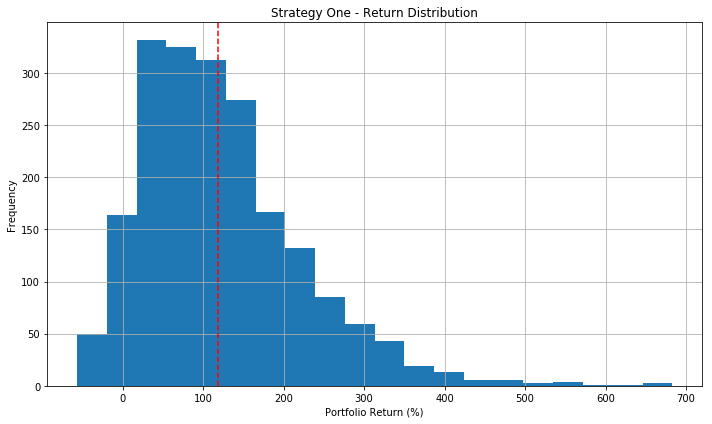

In [21]:
import statistics

print ("Strategy One Return - mean:{:.1f}%, std:{:.1f}%".format(statistics.mean(returns),statistics.stdev(returns)))
plt.figure(figsize=(10, 6))
num_bins = 20
plt.hist(returns,num_bins)
plt.xlabel('Portfolio Return (%)')
plt.ylabel("Frequency")
plt.title("Strategy One - Return Distribution")

plt.axvline(x=118.613, color="red", linestyle='--')
plt.grid(True)
plt.tight_layout()

plt.show()

# Strategy Three - Prune Losers; Reinvest in Winners and Newbies

In [26]:
num_iterations = 2000
returns = []
debug = False

for i in range(num_iterations):
    
    # Execute Strategy Three 

    portfolio = {}  # for storing portfolio info
    last = None   # to save a copy of the portfolio prior to rebalancing
    cash = START  # Start with $10M in cash

    for date, num_tickers, rebalance_period in zip(end_dates,portfolio_sizes, rebalance_periods):

        if debug:
            print('Portfolio: {}'.format(date))
        start, end = rebalance_period

        if last is None:  # Build the portfolio by investing starter cash evenly in a number of tickers

            if debug:
                print("Invest Evenly into {} tickers!".format(num_tickers))

            portfolio[date] = {}
            # Randomly select a set number of tickers from the prospect list (SHOTGUN)
            portfolio[date]['tickers'] = random_select(prospects[date], num_tickers)  
            portfolio[date]['num_shares'] = [0 for x in portfolio[date]['tickers']]

            # Invest cash evenly between the tickers
            invest = start_cash/num_tickers  
            portfolio[date]['num_shares'] = invest_evenly(portfolio[date]['tickers'], \
                                                         portfolio[date]['num_shares'], \
                                                         invest, start, end, debug=debug)

            last = portfolio[date]   # Save a copy of the portfolio for later iterations
            cash = 0  # No more cash left

        else:   # Rebalance portfolio - Let Winners run, Cut Losers Loose

            if debug:
                print("Let Winners run!")

            portfolio[date] = {}
            new_portfolio = {}
            loser_tickers = []
            loser_holdings = []
            newbie_tickers = []
            newbie_holdings = []

            # If a ticker in the portfolio is on the new prospect list, keep it as a Winner.
            # If a ticker is not on the new prospect list, sell its position for cash
            winners, losers = identify_winners(last['tickers'], prospects[date])
            
            if len(losers) is 0:  # if there are no losers
                new_portfolio = last  # no change to the portfolio
                if debug:
                    print('No change to Portfolio.')
                    print('Winners: {}'.format(winners))
            else:    
                # create new portfolio by pruning the losers
                new_portfolio, loser_tickers,loser_holdings = prune_losers(last, losers, debug=debug)  

                # Liquidate Losers for cash during rebalance period
                cash += liquidate(loser_tickers, loser_holdings, start, end, debug=debug)

                if debug:
                    print('Winners: {}'.format(winners))
                    print('Losers: {}'.format(losers))
                    print('Cash harvested from Losers: ${:.2f}'.format(cash))   
          
                if len(winners) >= num_tickers:
                    # If number of winners exceed the target ticker numbers
                    # Skip investing into newbies, cash will be reinvested into Winners
                    if debug:
                        print("{} Winners. No need for new prospects!".format(len(winners)))

                else:
                    # Pick newbies from prospect list and invest into them.
                    # If there is cash left over, it will be reinvested into Winners
                    
                    num_newbies = num_tickers - len(winners)
                    standard_invest = START/num_tickers  # standard amount to invest per ticker 
                    available_invest = cash/num_newbies   # available amount to invest per ticker

                    if available_invest <= standard_invest:
                        # If available amount per ticker is less than standard amount
                        # Then simply invest what is available
                        invest = available_invest
                        cash = 0  # then there will be no left-over cash
                        if debug:
                            print('No extra cash!')
                    else:
                        # If available amount per ticker is more than standard amount
                        # Then invest the standard amount.
                        invest = standard_invest
                        cash -= invest * num_newbies  # There is left-over cash
                        if debug:
                            print('Extra cash!')

                    # Randomly select new tickers from the prospect list
                    newbie_tickers = random_select(prospects[date], num_newbies, winners)
                    newbie_holdings = [0 for x in newbie_tickers]

                    newbie_holdings = invest_evenly(newbie_tickers, newbie_holdings, \
                                                             invest, start, end, debug=debug)                
           
            if cash > 0 and len(new_portfolio['tickers']) > 0:
                # If there is cash left over and there are winners left, invest it evenly into the Winners
                
                num_winners = len(new_portfolio['tickers'])
                if debug:
                    print("Invest ${:.2f} into {} Winners!".format(cash, num_winners))

                # Invest cash evenly between the tickers
                invest = cash/num_winners  
                new_portfolio['num_shares'] = invest_evenly(new_portfolio['tickers'],new_portfolio['num_shares'], \
                                                             invest, start, end, debug=debug)
                cash = 0  # No more cash left

            # Merge Newbies and Winners into final portfolio 
            if debug:
                print('Merge:')
                print('Newbies:{}'.format(newbie_tickers))
                print('Winners:{}'.format(new_portfolio['tickers']))
                print('Num Tickers:{}'.format(len(newbie_tickers)+len(new_portfolio['tickers'])))
            
            portfolio[date]['tickers'] = new_portfolio['tickers'] + newbie_tickers
            portfolio[date]['num_shares'] = new_portfolio['num_shares'] + newbie_holdings
            
            last = portfolio[date].copy()   # Save portfolio for later iterations

    # Calculate value of the stock holdings on target date
    equity = portfolio_value(last['tickers'], last['num_shares'], target_date)
    total = equity + cash
    
    # Calculate and save portfolio return
    portfolio_return = (total/start_cash-1)*100
    returns.append(portfolio_return)

    print('Equity is valued at: ${:.2f}'.format(equity))
    print('Cash Position: ${:.2f}'.format(cash))
    print('Portfolio Total: ${:.2f}'.format(total))
    print('Portfolio appreciates by {:.1f} %'.format(portfolio_return))
    print('\n')

Equity is valued at: $33210585.39
Cash Position: $0.00
Portfolio Total: $33210585.39
Portfolio appreciates by 232.1 %


Equity is valued at: $25388096.87
Cash Position: $0.00
Portfolio Total: $25388096.87
Portfolio appreciates by 153.9 %


Equity is valued at: $36132350.13
Cash Position: $0.00
Portfolio Total: $36132350.13
Portfolio appreciates by 261.3 %


Equity is valued at: $25760775.05
Cash Position: $0.00
Portfolio Total: $25760775.05
Portfolio appreciates by 157.6 %


Equity is valued at: $19015099.94
Cash Position: $0.00
Portfolio Total: $19015099.94
Portfolio appreciates by 90.2 %


Equity is valued at: $15274186.52
Cash Position: $0.00
Portfolio Total: $15274186.52
Portfolio appreciates by 52.7 %


Equity is valued at: $21368308.69
Cash Position: $0.00
Portfolio Total: $21368308.69
Portfolio appreciates by 113.7 %


Equity is valued at: $17949530.51
Cash Position: $0.00
Portfolio Total: $17949530.51
Portfolio appreciates by 79.5 %


Equity is valued at: $28485012.04
Cash Posi

Equity is valued at: $35653340.96
Cash Position: $0.00
Portfolio Total: $35653340.96
Portfolio appreciates by 256.5 %


Equity is valued at: $22437014.95
Cash Position: $0.00
Portfolio Total: $22437014.95
Portfolio appreciates by 124.4 %


Equity is valued at: $46146779.42
Cash Position: $0.00
Portfolio Total: $46146779.42
Portfolio appreciates by 361.5 %


Equity is valued at: $30336212.40
Cash Position: $0.00
Portfolio Total: $30336212.40
Portfolio appreciates by 203.4 %


Equity is valued at: $22830418.39
Cash Position: $0.00
Portfolio Total: $22830418.39
Portfolio appreciates by 128.3 %


Equity is valued at: $34384575.85
Cash Position: $0.00
Portfolio Total: $34384575.85
Portfolio appreciates by 243.8 %


Equity is valued at: $36978423.59
Cash Position: $0.00
Portfolio Total: $36978423.59
Portfolio appreciates by 269.8 %


Equity is valued at: $22684905.27
Cash Position: $0.00
Portfolio Total: $22684905.27
Portfolio appreciates by 126.8 %


Equity is valued at: $41262238.76
Cash P

Equity is valued at: $19351321.56
Cash Position: $0.00
Portfolio Total: $19351321.56
Portfolio appreciates by 93.5 %


Equity is valued at: $49438383.99
Cash Position: $0.00
Portfolio Total: $49438383.99
Portfolio appreciates by 394.4 %


Equity is valued at: $32884262.03
Cash Position: $0.00
Portfolio Total: $32884262.03
Portfolio appreciates by 228.8 %


Equity is valued at: $40596222.69
Cash Position: $0.00
Portfolio Total: $40596222.69
Portfolio appreciates by 306.0 %


Equity is valued at: $40043326.04
Cash Position: $0.00
Portfolio Total: $40043326.04
Portfolio appreciates by 300.4 %


Equity is valued at: $23703493.20
Cash Position: $0.00
Portfolio Total: $23703493.20
Portfolio appreciates by 137.0 %


Equity is valued at: $42770491.88
Cash Position: $0.00
Portfolio Total: $42770491.88
Portfolio appreciates by 327.7 %


Equity is valued at: $37713980.48
Cash Position: $0.00
Portfolio Total: $37713980.48
Portfolio appreciates by 277.1 %


Equity is valued at: $24546254.47
Cash Po

Equity is valued at: $28520908.57
Cash Position: $0.00
Portfolio Total: $28520908.57
Portfolio appreciates by 185.2 %


Equity is valued at: $19412847.95
Cash Position: $0.00
Portfolio Total: $19412847.95
Portfolio appreciates by 94.1 %


Equity is valued at: $30165840.95
Cash Position: $0.00
Portfolio Total: $30165840.95
Portfolio appreciates by 201.7 %


Equity is valued at: $52769673.50
Cash Position: $0.00
Portfolio Total: $52769673.50
Portfolio appreciates by 427.7 %


Equity is valued at: $18467650.56
Cash Position: $0.00
Portfolio Total: $18467650.56
Portfolio appreciates by 84.7 %


Equity is valued at: $23384618.06
Cash Position: $0.00
Portfolio Total: $23384618.06
Portfolio appreciates by 133.8 %


Equity is valued at: $27165156.96
Cash Position: $0.00
Portfolio Total: $27165156.96
Portfolio appreciates by 171.7 %


Equity is valued at: $22915338.72
Cash Position: $0.00
Portfolio Total: $22915338.72
Portfolio appreciates by 129.2 %


Equity is valued at: $38781320.38
Cash Pos

Equity is valued at: $23375430.02
Cash Position: $0.00
Portfolio Total: $23375430.02
Portfolio appreciates by 133.8 %


Equity is valued at: $21772031.94
Cash Position: $0.00
Portfolio Total: $21772031.94
Portfolio appreciates by 117.7 %


Equity is valued at: $45209587.53
Cash Position: $0.00
Portfolio Total: $45209587.53
Portfolio appreciates by 352.1 %


Equity is valued at: $17538483.73
Cash Position: $0.00
Portfolio Total: $17538483.73
Portfolio appreciates by 75.4 %


Equity is valued at: $35056547.42
Cash Position: $0.00
Portfolio Total: $35056547.42
Portfolio appreciates by 250.6 %


Equity is valued at: $50057492.93
Cash Position: $0.00
Portfolio Total: $50057492.93
Portfolio appreciates by 400.6 %


Equity is valued at: $20334713.51
Cash Position: $0.00
Portfolio Total: $20334713.51
Portfolio appreciates by 103.3 %


Equity is valued at: $30435270.53
Cash Position: $0.00
Portfolio Total: $30435270.53
Portfolio appreciates by 204.4 %


Equity is valued at: $32805020.92
Cash Po

Equity is valued at: $41326119.76
Cash Position: $0.00
Portfolio Total: $41326119.76
Portfolio appreciates by 313.3 %


Equity is valued at: $35072915.15
Cash Position: $0.00
Portfolio Total: $35072915.15
Portfolio appreciates by 250.7 %


Equity is valued at: $27126319.77
Cash Position: $0.00
Portfolio Total: $27126319.77
Portfolio appreciates by 171.3 %


Equity is valued at: $17376277.41
Cash Position: $0.00
Portfolio Total: $17376277.41
Portfolio appreciates by 73.8 %


Equity is valued at: $36203656.19
Cash Position: $0.00
Portfolio Total: $36203656.19
Portfolio appreciates by 262.0 %


Equity is valued at: $36872965.71
Cash Position: $0.00
Portfolio Total: $36872965.71
Portfolio appreciates by 268.7 %


Equity is valued at: $26791998.75
Cash Position: $0.00
Portfolio Total: $26791998.75
Portfolio appreciates by 167.9 %


Equity is valued at: $38070193.01
Cash Position: $0.00
Portfolio Total: $38070193.01
Portfolio appreciates by 280.7 %


Equity is valued at: $31500563.58
Cash Po

Equity is valued at: $25066297.12
Cash Position: $0.00
Portfolio Total: $25066297.12
Portfolio appreciates by 150.7 %


Equity is valued at: $22708209.69
Cash Position: $0.00
Portfolio Total: $22708209.69
Portfolio appreciates by 127.1 %


Equity is valued at: $29952592.45
Cash Position: $0.00
Portfolio Total: $29952592.45
Portfolio appreciates by 199.5 %


Equity is valued at: $39029301.05
Cash Position: $0.00
Portfolio Total: $39029301.05
Portfolio appreciates by 290.3 %


Equity is valued at: $26162694.00
Cash Position: $0.00
Portfolio Total: $26162694.00
Portfolio appreciates by 161.6 %


Equity is valued at: $28231373.53
Cash Position: $0.00
Portfolio Total: $28231373.53
Portfolio appreciates by 182.3 %


Equity is valued at: $23879646.56
Cash Position: $0.00
Portfolio Total: $23879646.56
Portfolio appreciates by 138.8 %


Equity is valued at: $23499693.50
Cash Position: $0.00
Portfolio Total: $23499693.50
Portfolio appreciates by 135.0 %


Equity is valued at: $28684855.15
Cash P

Equity is valued at: $31252585.71
Cash Position: $0.00
Portfolio Total: $31252585.71
Portfolio appreciates by 212.5 %


Equity is valued at: $30479833.73
Cash Position: $0.00
Portfolio Total: $30479833.73
Portfolio appreciates by 204.8 %


Equity is valued at: $21319741.85
Cash Position: $0.00
Portfolio Total: $21319741.85
Portfolio appreciates by 113.2 %


Equity is valued at: $28364388.56
Cash Position: $0.00
Portfolio Total: $28364388.56
Portfolio appreciates by 183.6 %


Equity is valued at: $21370579.08
Cash Position: $0.00
Portfolio Total: $21370579.08
Portfolio appreciates by 113.7 %


Equity is valued at: $25633382.41
Cash Position: $0.00
Portfolio Total: $25633382.41
Portfolio appreciates by 156.3 %


Equity is valued at: $40809281.80
Cash Position: $0.00
Portfolio Total: $40809281.80
Portfolio appreciates by 308.1 %


Equity is valued at: $39502368.47
Cash Position: $0.00
Portfolio Total: $39502368.47
Portfolio appreciates by 295.0 %


Equity is valued at: $19017410.22
Cash P

Equity is valued at: $26132621.42
Cash Position: $0.00
Portfolio Total: $26132621.42
Portfolio appreciates by 161.3 %


Equity is valued at: $30780547.34
Cash Position: $0.00
Portfolio Total: $30780547.34
Portfolio appreciates by 207.8 %


Equity is valued at: $17267261.60
Cash Position: $0.00
Portfolio Total: $17267261.60
Portfolio appreciates by 72.7 %


Equity is valued at: $46376632.18
Cash Position: $0.00
Portfolio Total: $46376632.18
Portfolio appreciates by 363.8 %


Equity is valued at: $16793393.34
Cash Position: $0.00
Portfolio Total: $16793393.34
Portfolio appreciates by 67.9 %


Equity is valued at: $32475961.56
Cash Position: $0.00
Portfolio Total: $32475961.56
Portfolio appreciates by 224.8 %


Equity is valued at: $40276467.91
Cash Position: $0.00
Portfolio Total: $40276467.91
Portfolio appreciates by 302.8 %


Equity is valued at: $25869047.19
Cash Position: $0.00
Portfolio Total: $25869047.19
Portfolio appreciates by 158.7 %


Equity is valued at: $33062861.25
Cash Pos

Equity is valued at: $35759716.32
Cash Position: $0.00
Portfolio Total: $35759716.32
Portfolio appreciates by 257.6 %


Equity is valued at: $40229254.03
Cash Position: $0.00
Portfolio Total: $40229254.03
Portfolio appreciates by 302.3 %


Equity is valued at: $25858048.43
Cash Position: $0.00
Portfolio Total: $25858048.43
Portfolio appreciates by 158.6 %


Equity is valued at: $27772428.40
Cash Position: $0.00
Portfolio Total: $27772428.40
Portfolio appreciates by 177.7 %


Equity is valued at: $19008004.75
Cash Position: $0.00
Portfolio Total: $19008004.75
Portfolio appreciates by 90.1 %


Equity is valued at: $22734157.36
Cash Position: $0.00
Portfolio Total: $22734157.36
Portfolio appreciates by 127.3 %


Equity is valued at: $49476485.09
Cash Position: $0.00
Portfolio Total: $49476485.09
Portfolio appreciates by 394.8 %


Equity is valued at: $36780595.55
Cash Position: $0.00
Portfolio Total: $36780595.55
Portfolio appreciates by 267.8 %


Equity is valued at: $24373426.21
Cash Po

Equity is valued at: $32996902.46
Cash Position: $0.00
Portfolio Total: $32996902.46
Portfolio appreciates by 230.0 %


Equity is valued at: $28070831.77
Cash Position: $0.00
Portfolio Total: $28070831.77
Portfolio appreciates by 180.7 %


Equity is valued at: $16753891.72
Cash Position: $0.00
Portfolio Total: $16753891.72
Portfolio appreciates by 67.5 %


Equity is valued at: $45576472.28
Cash Position: $0.00
Portfolio Total: $45576472.28
Portfolio appreciates by 355.8 %


Equity is valued at: $41066183.56
Cash Position: $0.00
Portfolio Total: $41066183.56
Portfolio appreciates by 310.7 %


Equity is valued at: $36937619.25
Cash Position: $0.00
Portfolio Total: $36937619.25
Portfolio appreciates by 269.4 %


Equity is valued at: $40219342.78
Cash Position: $0.00
Portfolio Total: $40219342.78
Portfolio appreciates by 302.2 %


Equity is valued at: $24187277.78
Cash Position: $0.00
Portfolio Total: $24187277.78
Portfolio appreciates by 141.9 %


Equity is valued at: $33323298.48
Cash Po

Equity is valued at: $28228965.89
Cash Position: $0.00
Portfolio Total: $28228965.89
Portfolio appreciates by 182.3 %


Equity is valued at: $21699036.84
Cash Position: $0.00
Portfolio Total: $21699036.84
Portfolio appreciates by 117.0 %


Equity is valued at: $19890855.15
Cash Position: $0.00
Portfolio Total: $19890855.15
Portfolio appreciates by 98.9 %


Equity is valued at: $24679928.52
Cash Position: $0.00
Portfolio Total: $24679928.52
Portfolio appreciates by 146.8 %


Equity is valued at: $33822315.54
Cash Position: $0.00
Portfolio Total: $33822315.54
Portfolio appreciates by 238.2 %


Equity is valued at: $52465742.03
Cash Position: $0.00
Portfolio Total: $52465742.03
Portfolio appreciates by 424.7 %


Equity is valued at: $31113794.85
Cash Position: $0.00
Portfolio Total: $31113794.85
Portfolio appreciates by 211.1 %


Equity is valued at: $28004231.78
Cash Position: $0.00
Portfolio Total: $28004231.78
Portfolio appreciates by 180.0 %


Equity is valued at: $35788742.67
Cash Po

Equity is valued at: $36851467.49
Cash Position: $0.00
Portfolio Total: $36851467.49
Portfolio appreciates by 268.5 %


Equity is valued at: $26898279.27
Cash Position: $0.00
Portfolio Total: $26898279.27
Portfolio appreciates by 169.0 %


Equity is valued at: $49526258.71
Cash Position: $0.00
Portfolio Total: $49526258.71
Portfolio appreciates by 395.3 %


Equity is valued at: $27613623.53
Cash Position: $0.00
Portfolio Total: $27613623.53
Portfolio appreciates by 176.1 %


Equity is valued at: $22961253.42
Cash Position: $0.00
Portfolio Total: $22961253.42
Portfolio appreciates by 129.6 %


Equity is valued at: $18360383.00
Cash Position: $0.00
Portfolio Total: $18360383.00
Portfolio appreciates by 83.6 %


Equity is valued at: $27338424.24
Cash Position: $0.00
Portfolio Total: $27338424.24
Portfolio appreciates by 173.4 %


Equity is valued at: $22966079.71
Cash Position: $0.00
Portfolio Total: $22966079.71
Portfolio appreciates by 129.7 %


Equity is valued at: $33392357.90
Cash Po

Equity is valued at: $49030782.29
Cash Position: $0.00
Portfolio Total: $49030782.29
Portfolio appreciates by 390.3 %


Equity is valued at: $44842272.87
Cash Position: $0.00
Portfolio Total: $44842272.87
Portfolio appreciates by 348.4 %


Equity is valued at: $25136198.87
Cash Position: $0.00
Portfolio Total: $25136198.87
Portfolio appreciates by 151.4 %


Equity is valued at: $30483724.68
Cash Position: $0.00
Portfolio Total: $30483724.68
Portfolio appreciates by 204.8 %


Equity is valued at: $28170687.86
Cash Position: $0.00
Portfolio Total: $28170687.86
Portfolio appreciates by 181.7 %


Equity is valued at: $25170801.23
Cash Position: $0.00
Portfolio Total: $25170801.23
Portfolio appreciates by 151.7 %


Equity is valued at: $20867376.83
Cash Position: $0.00
Portfolio Total: $20867376.83
Portfolio appreciates by 108.7 %


Equity is valued at: $26396818.31
Cash Position: $0.00
Portfolio Total: $26396818.31
Portfolio appreciates by 164.0 %


Equity is valued at: $30122747.30
Cash P

Equity is valued at: $17569387.75
Cash Position: $0.00
Portfolio Total: $17569387.75
Portfolio appreciates by 75.7 %


Equity is valued at: $31842706.38
Cash Position: $0.00
Portfolio Total: $31842706.38
Portfolio appreciates by 218.4 %


Equity is valued at: $28690745.34
Cash Position: $0.00
Portfolio Total: $28690745.34
Portfolio appreciates by 186.9 %


Equity is valued at: $34716312.39
Cash Position: $0.00
Portfolio Total: $34716312.39
Portfolio appreciates by 247.2 %


Equity is valued at: $20920186.25
Cash Position: $0.00
Portfolio Total: $20920186.25
Portfolio appreciates by 109.2 %


Equity is valued at: $26953198.22
Cash Position: $0.00
Portfolio Total: $26953198.22
Portfolio appreciates by 169.5 %


Equity is valued at: $27390641.99
Cash Position: $0.00
Portfolio Total: $27390641.99
Portfolio appreciates by 173.9 %


Equity is valued at: $32713959.76
Cash Position: $0.00
Portfolio Total: $32713959.76
Portfolio appreciates by 227.1 %


Equity is valued at: $27075866.93
Cash Po

Equity is valued at: $34335099.53
Cash Position: $0.00
Portfolio Total: $34335099.53
Portfolio appreciates by 243.4 %


Equity is valued at: $20317739.07
Cash Position: $0.00
Portfolio Total: $20317739.07
Portfolio appreciates by 103.2 %


Equity is valued at: $35204201.30
Cash Position: $0.00
Portfolio Total: $35204201.30
Portfolio appreciates by 252.0 %


Equity is valued at: $53987953.95
Cash Position: $0.00
Portfolio Total: $53987953.95
Portfolio appreciates by 439.9 %


Equity is valued at: $28333007.64
Cash Position: $0.00
Portfolio Total: $28333007.64
Portfolio appreciates by 183.3 %


Equity is valued at: $39189389.72
Cash Position: $0.00
Portfolio Total: $39189389.72
Portfolio appreciates by 291.9 %


Equity is valued at: $34426744.76
Cash Position: $0.00
Portfolio Total: $34426744.76
Portfolio appreciates by 244.3 %


Equity is valued at: $31482903.60
Cash Position: $0.00
Portfolio Total: $31482903.60
Portfolio appreciates by 214.8 %


Equity is valued at: $26583749.88
Cash P

Equity is valued at: $23525060.73
Cash Position: $0.00
Portfolio Total: $23525060.73
Portfolio appreciates by 135.3 %


Equity is valued at: $28169618.23
Cash Position: $0.00
Portfolio Total: $28169618.23
Portfolio appreciates by 181.7 %


Equity is valued at: $23476342.62
Cash Position: $0.00
Portfolio Total: $23476342.62
Portfolio appreciates by 134.8 %


Equity is valued at: $28549845.65
Cash Position: $0.00
Portfolio Total: $28549845.65
Portfolio appreciates by 185.5 %


Equity is valued at: $32427213.54
Cash Position: $0.00
Portfolio Total: $32427213.54
Portfolio appreciates by 224.3 %


Equity is valued at: $16126362.26
Cash Position: $0.00
Portfolio Total: $16126362.26
Portfolio appreciates by 61.3 %


Equity is valued at: $20763643.50
Cash Position: $0.00
Portfolio Total: $20763643.50
Portfolio appreciates by 107.6 %


Equity is valued at: $33358104.50
Cash Position: $0.00
Portfolio Total: $33358104.50
Portfolio appreciates by 233.6 %


Equity is valued at: $55474448.90
Cash Po

Equity is valued at: $21694453.57
Cash Position: $0.00
Portfolio Total: $21694453.57
Portfolio appreciates by 116.9 %


Equity is valued at: $51113237.12
Cash Position: $0.00
Portfolio Total: $51113237.12
Portfolio appreciates by 411.1 %


Equity is valued at: $39402281.06
Cash Position: $0.00
Portfolio Total: $39402281.06
Portfolio appreciates by 294.0 %


Equity is valued at: $16779744.42
Cash Position: $0.00
Portfolio Total: $16779744.42
Portfolio appreciates by 67.8 %


Equity is valued at: $16726090.96
Cash Position: $0.00
Portfolio Total: $16726090.96
Portfolio appreciates by 67.3 %


Equity is valued at: $20705080.69
Cash Position: $0.00
Portfolio Total: $20705080.69
Portfolio appreciates by 107.1 %


Equity is valued at: $34221232.68
Cash Position: $0.00
Portfolio Total: $34221232.68
Portfolio appreciates by 242.2 %


Equity is valued at: $25169667.53
Cash Position: $0.00
Portfolio Total: $25169667.53
Portfolio appreciates by 151.7 %


Equity is valued at: $20249167.64
Cash Pos

Equity is valued at: $27714977.26
Cash Position: $0.00
Portfolio Total: $27714977.26
Portfolio appreciates by 177.1 %


Equity is valued at: $23640224.97
Cash Position: $0.00
Portfolio Total: $23640224.97
Portfolio appreciates by 136.4 %


Equity is valued at: $35178241.59
Cash Position: $0.00
Portfolio Total: $35178241.59
Portfolio appreciates by 251.8 %


Equity is valued at: $24148279.13
Cash Position: $0.00
Portfolio Total: $24148279.13
Portfolio appreciates by 141.5 %


Equity is valued at: $26373368.46
Cash Position: $0.00
Portfolio Total: $26373368.46
Portfolio appreciates by 163.7 %


Equity is valued at: $24502920.64
Cash Position: $0.00
Portfolio Total: $24502920.64
Portfolio appreciates by 145.0 %


Equity is valued at: $34998411.58
Cash Position: $0.00
Portfolio Total: $34998411.58
Portfolio appreciates by 250.0 %


Equity is valued at: $22941226.16
Cash Position: $0.00
Portfolio Total: $22941226.16
Portfolio appreciates by 129.4 %


Equity is valued at: $42617272.28
Cash P

Equity is valued at: $35810572.36
Cash Position: $0.00
Portfolio Total: $35810572.36
Portfolio appreciates by 258.1 %


Equity is valued at: $48151262.33
Cash Position: $0.00
Portfolio Total: $48151262.33
Portfolio appreciates by 381.5 %


Equity is valued at: $62575977.61
Cash Position: $0.00
Portfolio Total: $62575977.61
Portfolio appreciates by 525.8 %


Equity is valued at: $38149604.97
Cash Position: $0.00
Portfolio Total: $38149604.97
Portfolio appreciates by 281.5 %


Equity is valued at: $35471858.17
Cash Position: $0.00
Portfolio Total: $35471858.17
Portfolio appreciates by 254.7 %


Equity is valued at: $35569396.26
Cash Position: $0.00
Portfolio Total: $35569396.26
Portfolio appreciates by 255.7 %


Equity is valued at: $24683241.24
Cash Position: $0.00
Portfolio Total: $24683241.24
Portfolio appreciates by 146.8 %


Equity is valued at: $21837175.97
Cash Position: $0.00
Portfolio Total: $21837175.97
Portfolio appreciates by 118.4 %


Equity is valued at: $37063414.60
Cash P

Equity is valued at: $18949905.25
Cash Position: $0.00
Portfolio Total: $18949905.25
Portfolio appreciates by 89.5 %


Equity is valued at: $30761952.47
Cash Position: $0.00
Portfolio Total: $30761952.47
Portfolio appreciates by 207.6 %


Equity is valued at: $44171351.66
Cash Position: $0.00
Portfolio Total: $44171351.66
Portfolio appreciates by 341.7 %


Equity is valued at: $41844495.35
Cash Position: $0.00
Portfolio Total: $41844495.35
Portfolio appreciates by 318.4 %


Equity is valued at: $46863237.39
Cash Position: $0.00
Portfolio Total: $46863237.39
Portfolio appreciates by 368.6 %


Equity is valued at: $15272813.26
Cash Position: $0.00
Portfolio Total: $15272813.26
Portfolio appreciates by 52.7 %


Equity is valued at: $26196644.08
Cash Position: $0.00
Portfolio Total: $26196644.08
Portfolio appreciates by 162.0 %


Equity is valued at: $32888872.19
Cash Position: $0.00
Portfolio Total: $32888872.19
Portfolio appreciates by 228.9 %


Equity is valued at: $31180491.96
Cash Pos

Equity is valued at: $28928836.60
Cash Position: $0.00
Portfolio Total: $28928836.60
Portfolio appreciates by 189.3 %


Equity is valued at: $20378423.31
Cash Position: $0.00
Portfolio Total: $20378423.31
Portfolio appreciates by 103.8 %


Equity is valued at: $27728258.03
Cash Position: $0.00
Portfolio Total: $27728258.03
Portfolio appreciates by 177.3 %


Equity is valued at: $25683812.48
Cash Position: $0.00
Portfolio Total: $25683812.48
Portfolio appreciates by 156.8 %


Equity is valued at: $34939846.82
Cash Position: $0.00
Portfolio Total: $34939846.82
Portfolio appreciates by 249.4 %


Equity is valued at: $26778559.45
Cash Position: $0.00
Portfolio Total: $26778559.45
Portfolio appreciates by 167.8 %


Equity is valued at: $23460488.53
Cash Position: $0.00
Portfolio Total: $23460488.53
Portfolio appreciates by 134.6 %


Equity is valued at: $20306377.20
Cash Position: $0.00
Portfolio Total: $20306377.20
Portfolio appreciates by 103.1 %


Equity is valued at: $33866927.35
Cash P

Equity is valued at: $29835339.61
Cash Position: $0.00
Portfolio Total: $29835339.61
Portfolio appreciates by 198.4 %


Equity is valued at: $25260073.22
Cash Position: $0.00
Portfolio Total: $25260073.22
Portfolio appreciates by 152.6 %


Equity is valued at: $42659868.67
Cash Position: $0.00
Portfolio Total: $42659868.67
Portfolio appreciates by 326.6 %


Equity is valued at: $42930905.34
Cash Position: $0.00
Portfolio Total: $42930905.34
Portfolio appreciates by 329.3 %


Equity is valued at: $24117678.86
Cash Position: $0.00
Portfolio Total: $24117678.86
Portfolio appreciates by 141.2 %


Equity is valued at: $30329865.81
Cash Position: $0.00
Portfolio Total: $30329865.81
Portfolio appreciates by 203.3 %


Equity is valued at: $18203237.03
Cash Position: $0.00
Portfolio Total: $18203237.03
Portfolio appreciates by 82.0 %


Equity is valued at: $33410639.13
Cash Position: $0.00
Portfolio Total: $33410639.13
Portfolio appreciates by 234.1 %


Equity is valued at: $33167036.50
Cash Po

Equity is valued at: $29953070.82
Cash Position: $0.00
Portfolio Total: $29953070.82
Portfolio appreciates by 199.5 %


Equity is valued at: $43824784.87
Cash Position: $0.00
Portfolio Total: $43824784.87
Portfolio appreciates by 338.2 %


Equity is valued at: $32963165.04
Cash Position: $0.00
Portfolio Total: $32963165.04
Portfolio appreciates by 229.6 %


Equity is valued at: $18658955.80
Cash Position: $0.00
Portfolio Total: $18658955.80
Portfolio appreciates by 86.6 %


Equity is valued at: $33364770.49
Cash Position: $0.00
Portfolio Total: $33364770.49
Portfolio appreciates by 233.6 %


Equity is valued at: $26421589.29
Cash Position: $0.00
Portfolio Total: $26421589.29
Portfolio appreciates by 164.2 %


Equity is valued at: $32875203.34
Cash Position: $0.00
Portfolio Total: $32875203.34
Portfolio appreciates by 228.8 %


Equity is valued at: $17785114.39
Cash Position: $0.00
Portfolio Total: $17785114.39
Portfolio appreciates by 77.9 %


Equity is valued at: $39301036.20
Cash Pos

Equity is valued at: $31762004.41
Cash Position: $0.00
Portfolio Total: $31762004.41
Portfolio appreciates by 217.6 %


Equity is valued at: $32715064.30
Cash Position: $0.00
Portfolio Total: $32715064.30
Portfolio appreciates by 227.2 %


Equity is valued at: $20114040.25
Cash Position: $0.00
Portfolio Total: $20114040.25
Portfolio appreciates by 101.1 %


Equity is valued at: $29382536.53
Cash Position: $0.00
Portfolio Total: $29382536.53
Portfolio appreciates by 193.8 %


Equity is valued at: $23944212.90
Cash Position: $0.00
Portfolio Total: $23944212.90
Portfolio appreciates by 139.4 %


Equity is valued at: $54560138.56
Cash Position: $0.00
Portfolio Total: $54560138.56
Portfolio appreciates by 445.6 %


Equity is valued at: $26056266.22
Cash Position: $0.00
Portfolio Total: $26056266.22
Portfolio appreciates by 160.6 %


Equity is valued at: $25424447.01
Cash Position: $0.00
Portfolio Total: $25424447.01
Portfolio appreciates by 154.2 %


Equity is valued at: $14998275.77
Cash P

Equity is valued at: $28522883.36
Cash Position: $0.00
Portfolio Total: $28522883.36
Portfolio appreciates by 185.2 %


Equity is valued at: $16924411.91
Cash Position: $0.00
Portfolio Total: $16924411.91
Portfolio appreciates by 69.2 %


Equity is valued at: $31692342.22
Cash Position: $0.00
Portfolio Total: $31692342.22
Portfolio appreciates by 216.9 %


Equity is valued at: $24350109.23
Cash Position: $0.00
Portfolio Total: $24350109.23
Portfolio appreciates by 143.5 %


Equity is valued at: $31270675.36
Cash Position: $0.00
Portfolio Total: $31270675.36
Portfolio appreciates by 212.7 %


Equity is valued at: $39036263.64
Cash Position: $0.00
Portfolio Total: $39036263.64
Portfolio appreciates by 290.4 %


Equity is valued at: $35189646.53
Cash Position: $0.00
Portfolio Total: $35189646.53
Portfolio appreciates by 251.9 %


Equity is valued at: $35803185.43
Cash Position: $0.00
Portfolio Total: $35803185.43
Portfolio appreciates by 258.0 %


Equity is valued at: $39789825.17
Cash Po

Equity is valued at: $19063643.76
Cash Position: $0.00
Portfolio Total: $19063643.76
Portfolio appreciates by 90.6 %


Equity is valued at: $30421071.19
Cash Position: $0.00
Portfolio Total: $30421071.19
Portfolio appreciates by 204.2 %


Equity is valued at: $35814442.50
Cash Position: $0.00
Portfolio Total: $35814442.50
Portfolio appreciates by 258.1 %


Equity is valued at: $23370969.33
Cash Position: $0.00
Portfolio Total: $23370969.33
Portfolio appreciates by 133.7 %


Equity is valued at: $35289216.65
Cash Position: $0.00
Portfolio Total: $35289216.65
Portfolio appreciates by 252.9 %


Equity is valued at: $16815029.58
Cash Position: $0.00
Portfolio Total: $16815029.58
Portfolio appreciates by 68.2 %


Equity is valued at: $50893752.36
Cash Position: $0.00
Portfolio Total: $50893752.36
Portfolio appreciates by 408.9 %


Equity is valued at: $49535065.38
Cash Position: $0.00
Portfolio Total: $49535065.38
Portfolio appreciates by 395.4 %


Equity is valued at: $24999224.23
Cash Pos

Equity is valued at: $21796309.93
Cash Position: $0.00
Portfolio Total: $21796309.93
Portfolio appreciates by 118.0 %


Equity is valued at: $23592759.18
Cash Position: $0.00
Portfolio Total: $23592759.18
Portfolio appreciates by 135.9 %


Equity is valued at: $33573576.27
Cash Position: $0.00
Portfolio Total: $33573576.27
Portfolio appreciates by 235.7 %


Equity is valued at: $41799024.99
Cash Position: $0.00
Portfolio Total: $41799024.99
Portfolio appreciates by 318.0 %


Equity is valued at: $32623159.02
Cash Position: $0.00
Portfolio Total: $32623159.02
Portfolio appreciates by 226.2 %


Equity is valued at: $26271604.68
Cash Position: $0.00
Portfolio Total: $26271604.68
Portfolio appreciates by 162.7 %


Equity is valued at: $38963746.55
Cash Position: $0.00
Portfolio Total: $38963746.55
Portfolio appreciates by 289.6 %


Equity is valued at: $39371763.91
Cash Position: $0.00
Portfolio Total: $39371763.91
Portfolio appreciates by 293.7 %


Equity is valued at: $19391695.16
Cash P

Equity is valued at: $21848888.16
Cash Position: $0.00
Portfolio Total: $21848888.16
Portfolio appreciates by 118.5 %


Equity is valued at: $32709410.00
Cash Position: $0.00
Portfolio Total: $32709410.00
Portfolio appreciates by 227.1 %


Equity is valued at: $25505318.85
Cash Position: $0.00
Portfolio Total: $25505318.85
Portfolio appreciates by 155.1 %


Equity is valued at: $54777993.28
Cash Position: $0.00
Portfolio Total: $54777993.28
Portfolio appreciates by 447.8 %


Equity is valued at: $36026224.51
Cash Position: $0.00
Portfolio Total: $36026224.51
Portfolio appreciates by 260.3 %


Equity is valued at: $35830907.81
Cash Position: $0.00
Portfolio Total: $35830907.81
Portfolio appreciates by 258.3 %


Equity is valued at: $31657003.99
Cash Position: $0.00
Portfolio Total: $31657003.99
Portfolio appreciates by 216.6 %


Equity is valued at: $41677873.39
Cash Position: $0.00
Portfolio Total: $41677873.39
Portfolio appreciates by 316.8 %


Equity is valued at: $39640360.23
Cash P

Strategy Three Return - mean:208.0%, std:89.2%


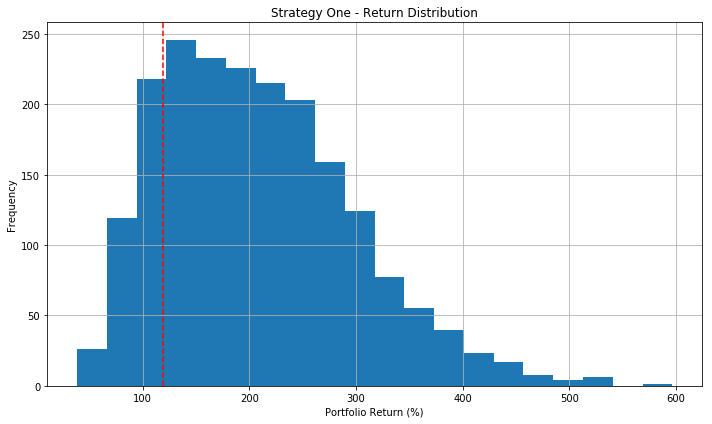

In [27]:
import statistics

print ("Strategy Three Return - mean:{:.1f}%, std:{:.1f}%".format(statistics.mean(returns),statistics.stdev(returns)))
plt.figure(figsize=(10, 6))
num_bins = 20
plt.hist(returns,num_bins)
plt.xlabel('Portfolio Return (%)')
plt.ylabel("Frequency")
plt.title("Strategy One - Return Distribution")

plt.axvline(x=118.613, color="red", linestyle='--')
plt.grid(True)
plt.tight_layout()

plt.show()